# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 10

In [2]:
cluster = '10'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 230
Num noneffect sequences: 230


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
136   chr2   95057163   95057164     rs872580      C         A   C      A   
101  chr19   18438073   18438074    rs2303696      T         C   T      C   
106  chr19   44644418   44644419   rs10426401      T         G   T      G   
70   chr17   45894775   45894776   rs11575896      G         A   G      A   
51   chr17   45747972   45747973   rs62054435      G         C   C      G   
197   chr4   89836583   89836584    rs2619361      C         A   C      A   
198   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
102  chr19   18506340   18506341    rs8109573      T         G   G      T   
147   chr2  127107344  127107345   rs76516995    NAN       NAN   C    A,G   
163   chr3   49007333   49007334    rs6781790      T         C   C      T   
149   chr2  127107345  127107346   rs78710909    NAN       NAN   G      C   
96   chr18   51198353   51198354    rs3819118      T         C   C  A,G,T   
192   chr4   89836157   89836158    rs1372519      A         G   A      G   
74   chr17   45941121   45941122  17_45941122      T         C   .      .   
122  chr19   44951428   44951429    rs7248162      T         C   T      C   
25   chr12   40224294   40224295    rs1388597      G         A   A      G   
78   chr17   45947195   45947196   rs62062785      T         G   G    A,T   
76   chr17   45942313   45942314   rs62062770      T         C   T      C   
8    chr10   15515276   15515277     rs896434      T         G   T      G   
202   chr5  103120549  103120550      rs26523      T         C   C      T   
137   chr2   95076932   95076933    rs3105101      C         A   C      A   
158  chr20    6006303    6006304    rs6085343      G         A   G      A   
162   chr3   48740593   48740594    rs6442130      G         A   A      G   
187   chr4   89800728   89800729   rs17016188      T         C   T      C   
107  chr19   44723890   44723891  rs150820726      T         A   A      T   
36   chr16   31033575   31033576   rs12445650      G         A   G      A   
200   chr5  102910364  102910365   rs17154825      T         C   T      C   
169   chr3   52288193   52288194  rs146664705      G         C   C    A,G   
145   chr2  127106969  127106970   rs11554586      A         G   G      A   
130  chr19   45001918   45001919   rs35194062      A         C   C      A   
..     ...        ...        ...          ...    ...       ...  ..    ...   
206   chr7   23086302   23086303    rs9691762      C         G   G    A,C   
224   chr8   27608797   27608798    rs1532278      T         C   T      C   
207   chr7   23106492   23106493    rs2072368      T         C   C      T   
40   chr16   50732215   50732216    rs3135499      C         A   A      C   
3     chr1  207565781  207565782    rs3886100      A         G   A      G   
188   chr4   89801281   89801282    rs2619373      A         G   G      A   
175   chr4     912342     912343   rs11248057      G         C   C      G   
83   chr17   46002672   46002673   rs62064663      T         G   T      G   
150   chr2  127107523  127107524   rs13032148      A         G   G      A   
4    chr10   15500585   15500586   rs10906910      T         C   T    A,C   
132  chr19   45045876   45045877  rs112481437      A         G   G      A   
176   chr4     973550     973551  rs113075206      G         C   C      G   
64   chr17   45849625   45849626   rs56269136      T         C   C      T   
194   chr4   89836353   89836354    rs1372520    NAN       NAN   T      C   
205   chr6   47477280   47477281    rs1004173      T         C   C      T   
73   chr17   45941032   45941033   rs62061733      G         A   A      G   
203   chr5  103120599  103120600      rs26524      G         A   A      G   
85   chr17   46012781   46012782   rs75666751      C         A   A      C   
116  chr19   44891078   44891079   rs71352238      C         T   T      C   
151   chr2  127107527  127107528  2_127107528    NAN       NAN   .      .   
1  

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs872580   ||    chr2 : 95057163 - 95057164   ||    Locus: 136   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  4.04E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.2568   ||   Center / 200bp : 0.2707
Noneffect Sequence : TTCCATGGCACTCGAGCAGC


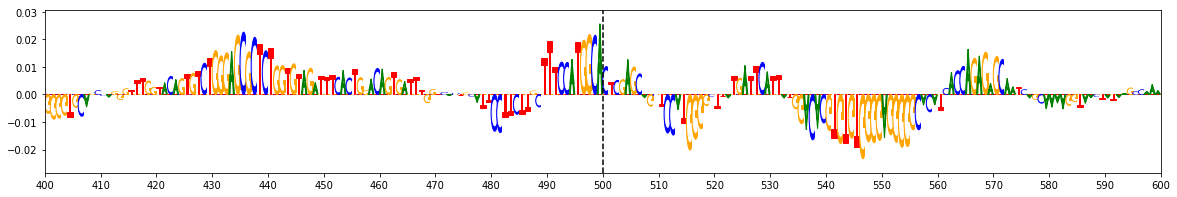

Effect Allele : C   ||   Explain Score : 0.0332   ||   Center / 200bp : 0.0457
Effect Sequence : TTCCATGGCCCTCGAGCAGC


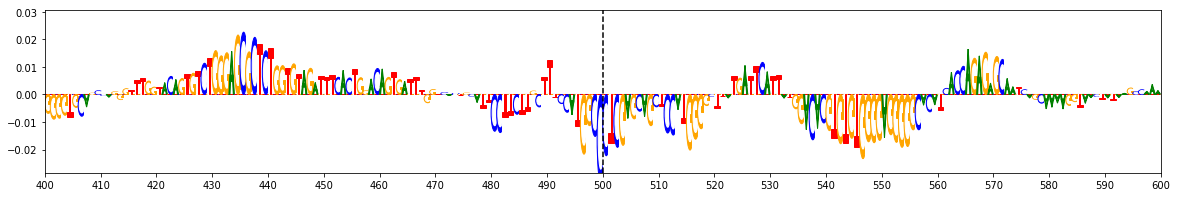

Allele Ratio : 0.1291   ||   Allele Difference : -0.4524  ||  ISM Score : -0.7019  ||  deltaSVM Score : -4.0875


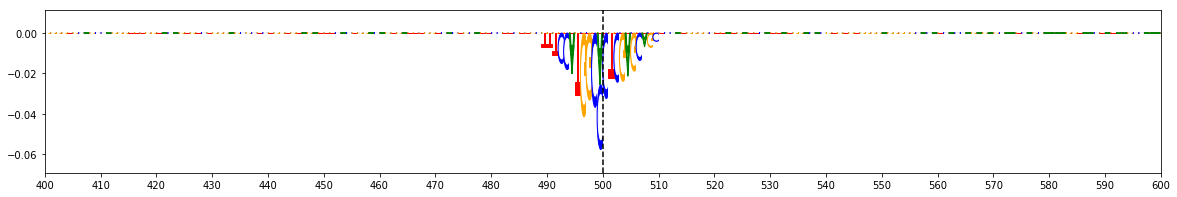


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2303696   ||    chr19 : 18438073 - 18438074   ||    Locus: 101   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  8.40E-01
Alzheimers_Kunkle_2019 		  1.89E-05
Alzheimers_Lambert_2013 	  NAN

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.6228   ||   Center / 200bp : 0.4813
Noneffect Sequence : GGCCGTCCCCGCCCCGAACC


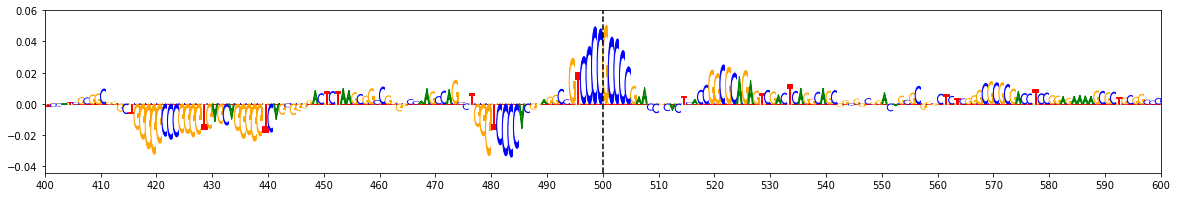

Effect Allele : T   ||   Explain Score : 0.2399   ||   Center / 200bp : 0.2624
Effect Sequence : GGCCGTCCCTGCCCCGAACC


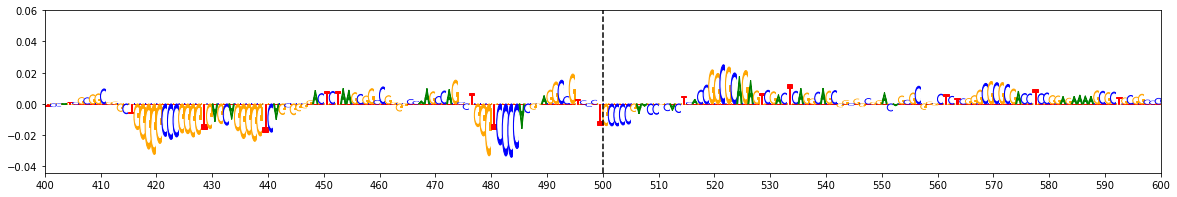

Allele Ratio : 0.3852   ||   Allele Difference : -0.4837  ||  ISM Score : -0.7759  ||  deltaSVM Score : -4.3733


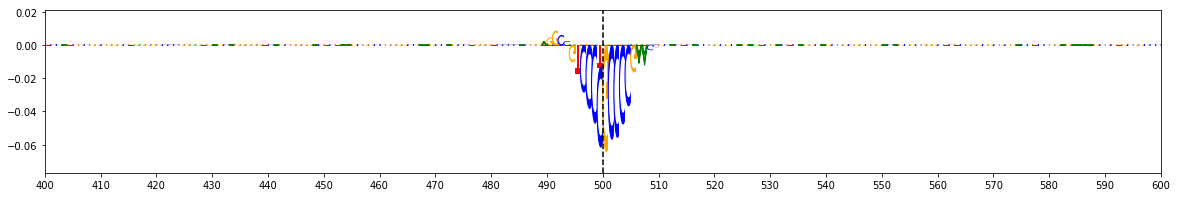


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 106   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.8807   ||   Center / 200bp : 0.6627
Noneffect Sequence : CAACACGGGGCGGGCACAAG


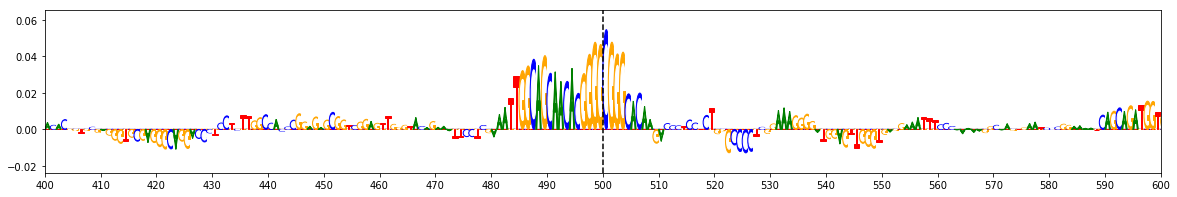

Effect Allele : T   ||   Explain Score : 0.5239   ||   Center / 200bp : 0.5384
Effect Sequence : CAACACGGGTCGGGCACAAG


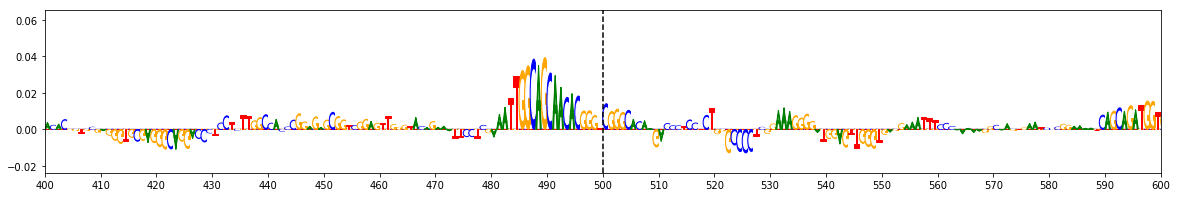

Allele Ratio : 0.5949   ||   Allele Difference : -0.359  ||  ISM Score : -0.5741  ||  deltaSVM Score : -3.2753


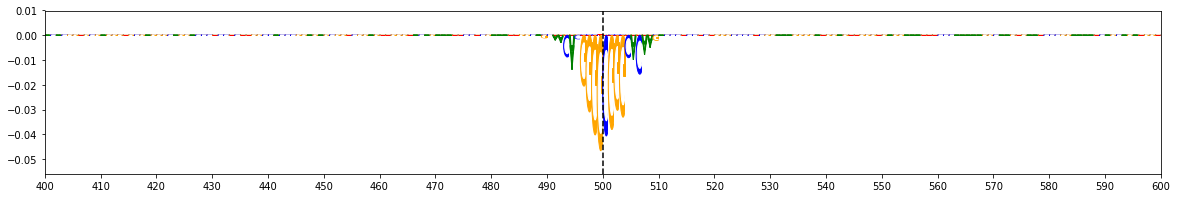


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 70   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.4586   ||   Center / 200bp : 0.7051
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


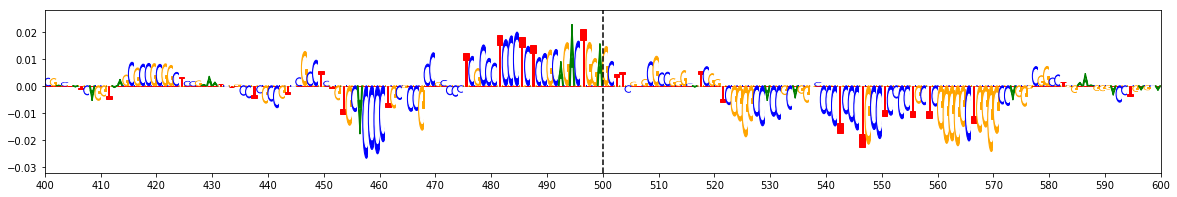

Effect Allele : G   ||   Explain Score : 0.3076   ||   Center / 200bp : 0.6162
Effect Sequence : GCAGACTGGGGCTTCGTGCG


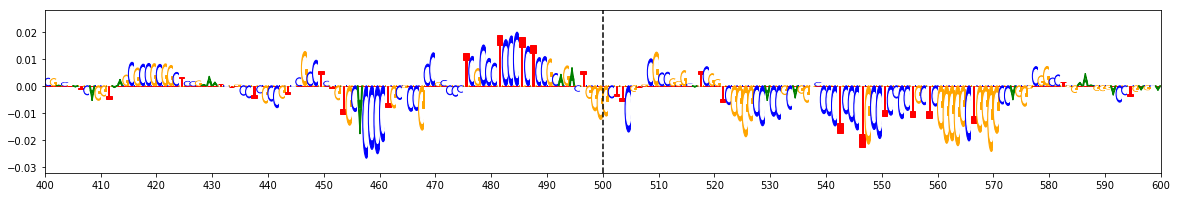

Allele Ratio : 0.6708   ||   Allele Difference : -0.2217  ||  ISM Score : -0.356  ||  deltaSVM Score : -2.0376


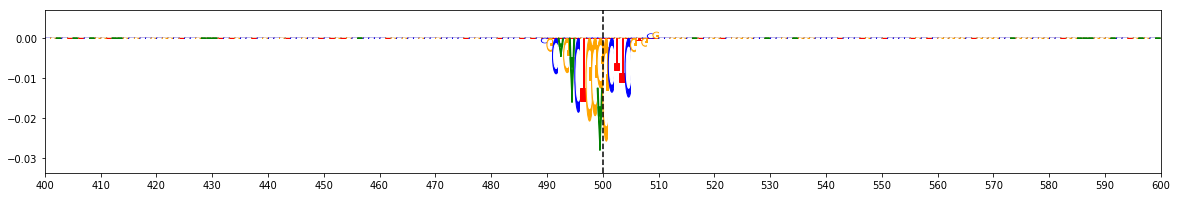


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054435   ||    chr17 : 45747972 - 45747973   ||    Locus: 51   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.95E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.1278   ||   Center / 200bp : 0.8291
Noneffect Sequence : CTTTCTGTGCAGAAGGCTGG


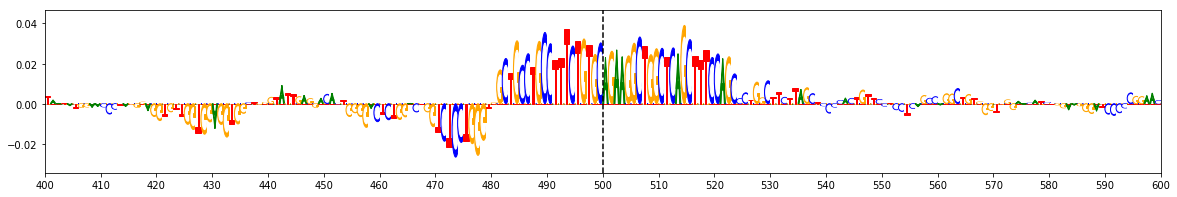

Effect Allele : G   ||   Explain Score : 0.9304   ||   Center / 200bp : 0.8002
Effect Sequence : CTTTCTGTGGAGAAGGCTGG


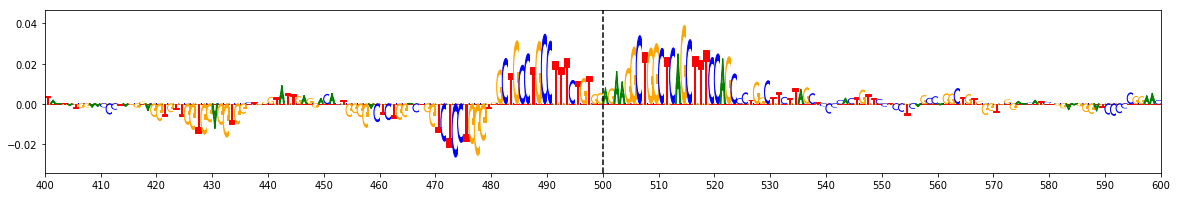

Allele Ratio : 0.8249   ||   Allele Difference : -0.1974  ||  ISM Score : -0.3033  ||  deltaSVM Score : -1.7579


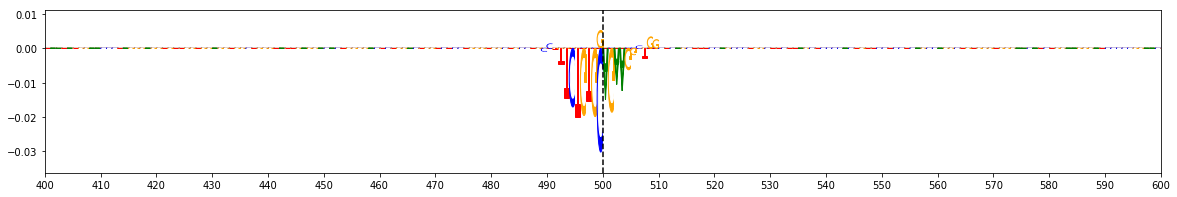


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619361   ||    chr4 : 89836583 - 89836584   ||    Locus: 197   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  2.97E-07
23andme_PD_hg38 		  1.36E-08

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.2434   ||   Center / 200bp : 0.3205
Noneffect Sequence : GTCTCTTTCATTAGGCTCCC


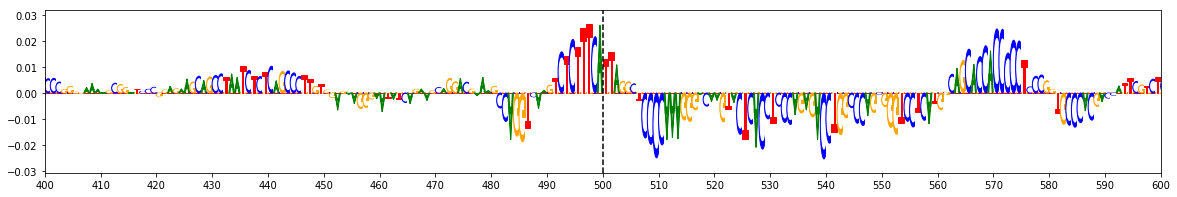

Effect Allele : C   ||   Explain Score : 0.0837   ||   Center / 200bp : 0.1395
Effect Sequence : GTCTCTTTCCTTAGGCTCCC


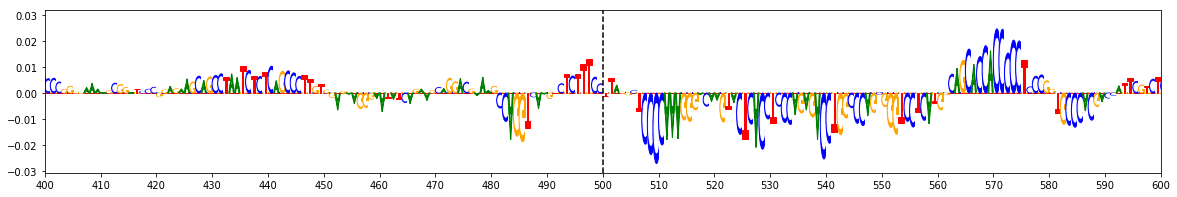

Allele Ratio : 0.3441   ||   Allele Difference : -0.177  ||  ISM Score : -0.2767  ||  deltaSVM Score : -1.6123


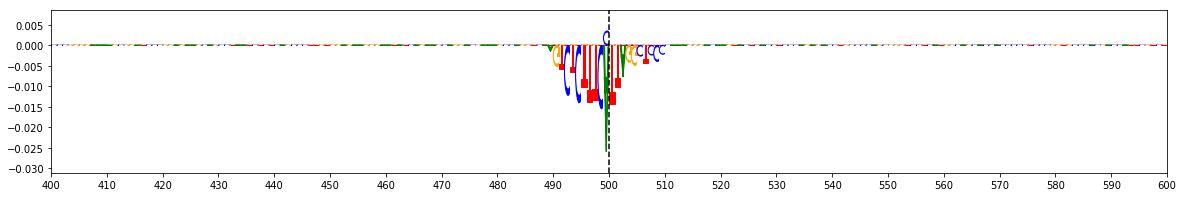


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 198   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.9945   ||   Center / 200bp : 0.6192
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


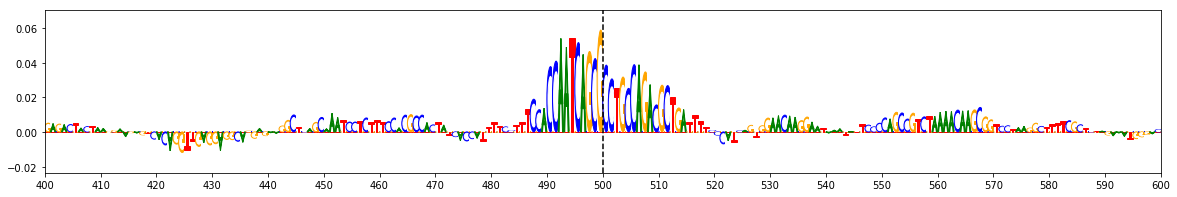

Effect Allele : NAN   ||   Explain Score : 0.6999   ||   Center / 200bp : 0.5317
Effect Sequence : CCAATCAGCCCCTGCCAGAC


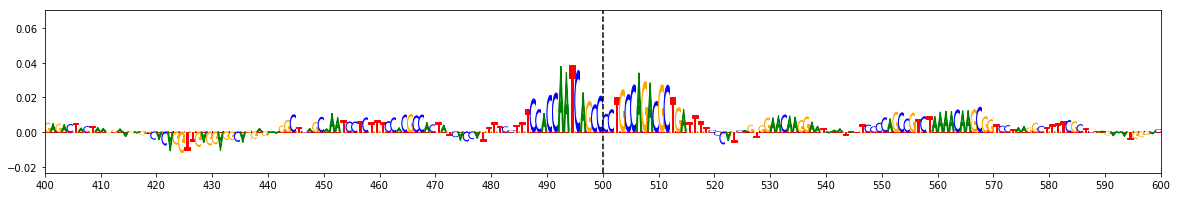

Allele Ratio : 0.7038   ||   Allele Difference : -0.2948  ||  ISM Score : -0.4396  ||  deltaSVM Score : -2.7539


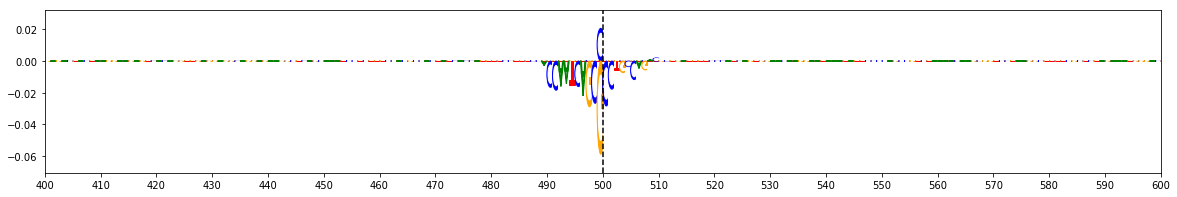


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8109573   ||    chr19 : 18506340 - 18506341   ||    Locus: 102   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.13E-01
Alzheimers_Kunkle_2019 		  8.71E-05
Alzheimers_Lambert_2013 	  6.88E-05

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.6843   ||   Center / 200bp : 0.7118
Noneffect Sequence : GGACACCCGGGCTGCTTCAG


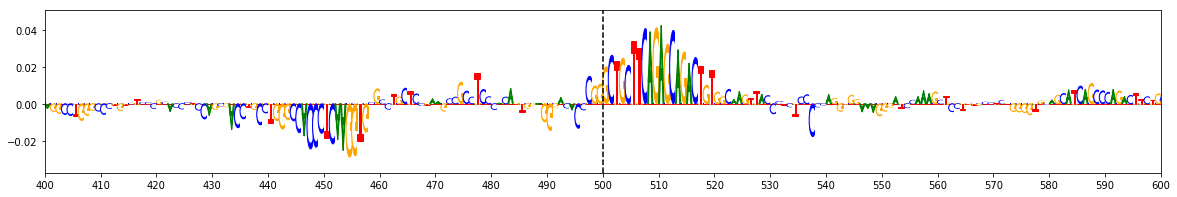

Effect Allele : T   ||   Explain Score : 0.579   ||   Center / 200bp : 0.6763
Effect Sequence : GGACACCCGTGCTGCTTCAG


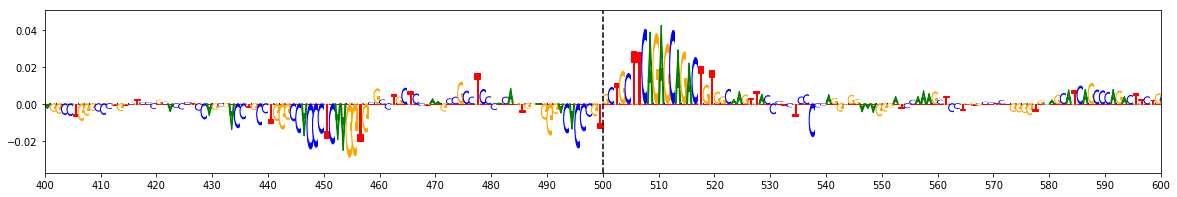

Allele Ratio : 0.8461   ||   Allele Difference : -0.1871  ||  ISM Score : -0.2962  ||  deltaSVM Score : -1.7112


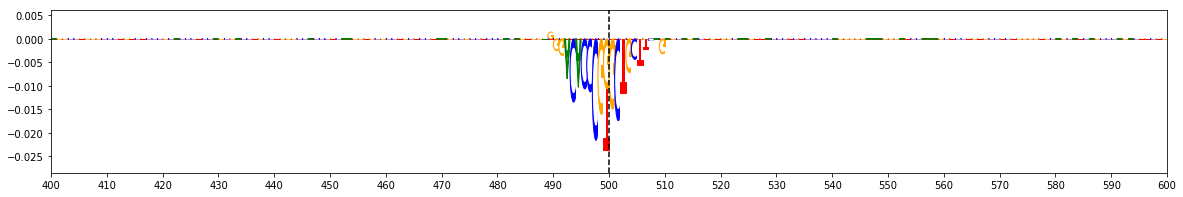


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76516995   ||    chr2 : 127107344 - 127107345   ||    Locus: 147   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  NAN
Alzheimers_Kunkle_2019 		  4.83E-10

Coloc:  False

Noneffect Allele : NAN   ||   Explain Score : 1.6043   ||   Center / 200bp : 0.7253
Noneffect Sequence : GCACCGCCCCGGGGCGGGGA


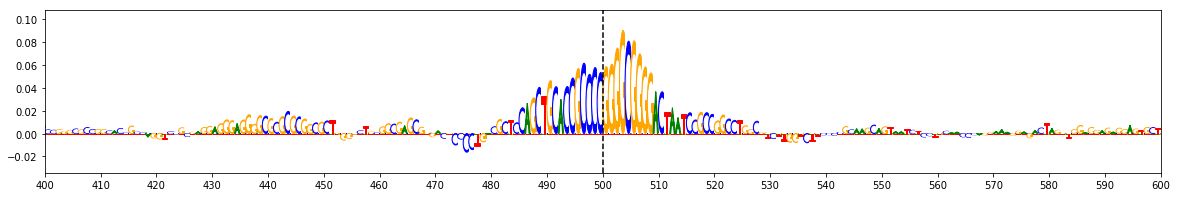

Effect Allele : NAN   ||   Explain Score : 1.4586   ||   Center / 200bp : 0.6995
Effect Sequence : GCACCGCCCAGGGGCGGGGA


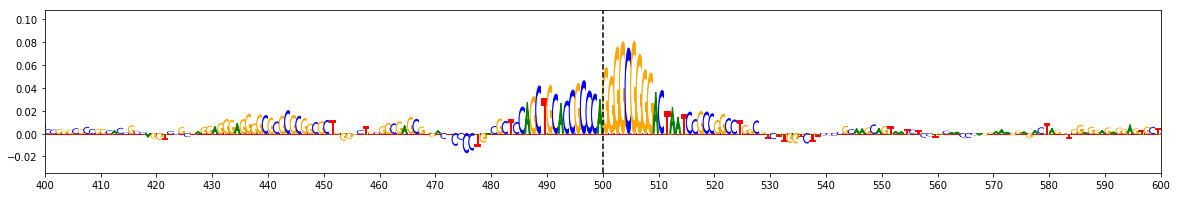

Allele Ratio : 0.9091   ||   Allele Difference : -0.1473  ||  ISM Score : -0.1337  ||  deltaSVM Score : -1.8013


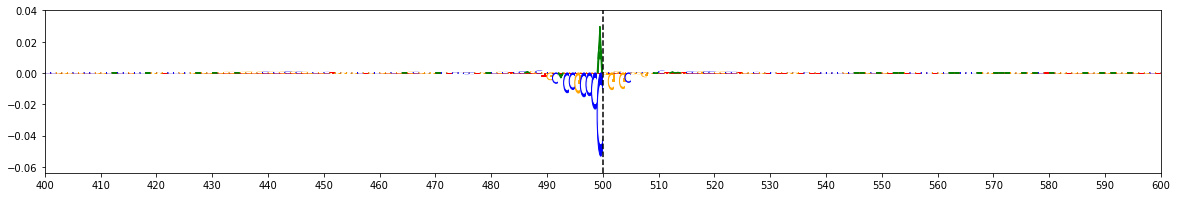


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 163   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.8036   ||   Center / 200bp : 0.3861
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


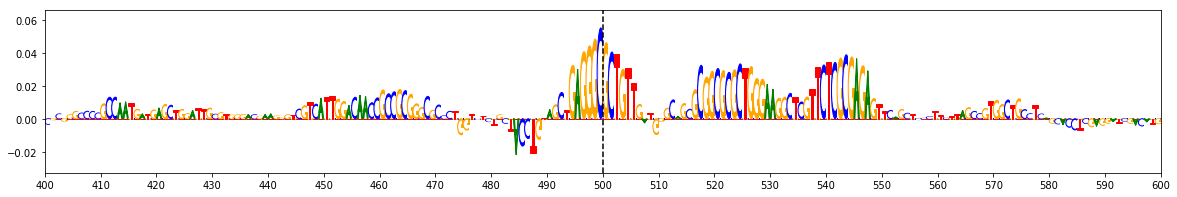

Effect Allele : T   ||   Explain Score : 0.3998   ||   Center / 200bp : 0.2381
Effect Sequence : AGCTGAGGGTGCTGTTGATG


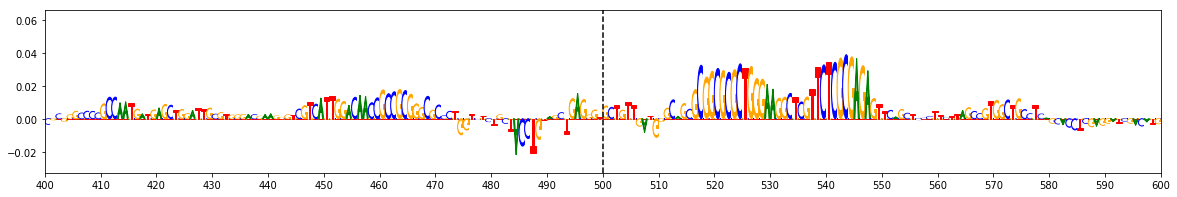

Allele Ratio : 0.4975   ||   Allele Difference : -0.4256  ||  ISM Score : -0.6705  ||  deltaSVM Score : -3.8733


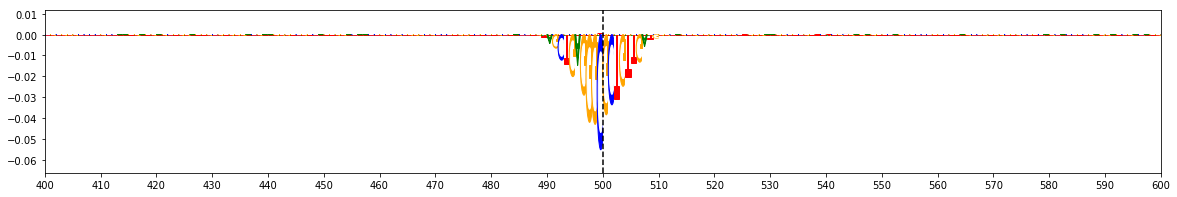


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs78710909   ||    chr2 : 127107345 - 127107346   ||    Locus: 149   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  4.44E-07
Alzheimers_Lambert_2013 	  NAN

Coloc:  False

Noneffect Allele : NAN   ||   Explain Score : 1.6154   ||   Center / 200bp : 0.7293
Noneffect Sequence : CACCGCCCCGGGGCGGGGAC


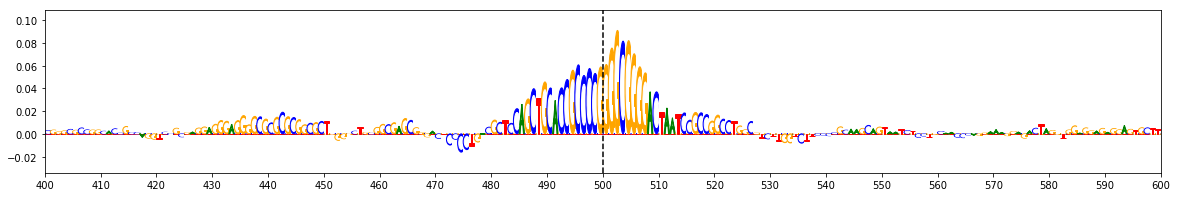

Effect Allele : NAN   ||   Explain Score : 1.52   ||   Center / 200bp : 0.7117
Effect Sequence : CACCGCCCCCGGGCGGGGAC


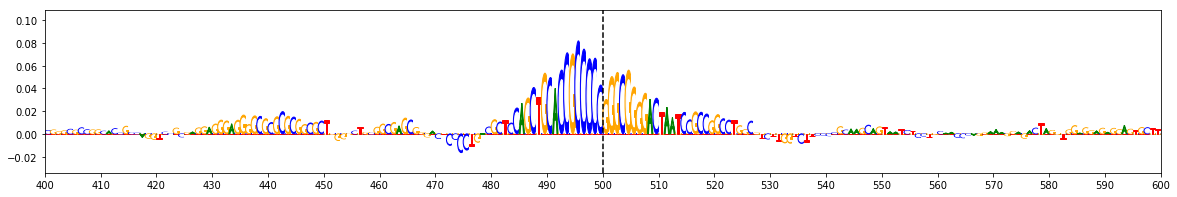

Allele Ratio : 0.9409   ||   Allele Difference : -0.0963  ||  ISM Score : -0.0565  ||  deltaSVM Score : -1.2256


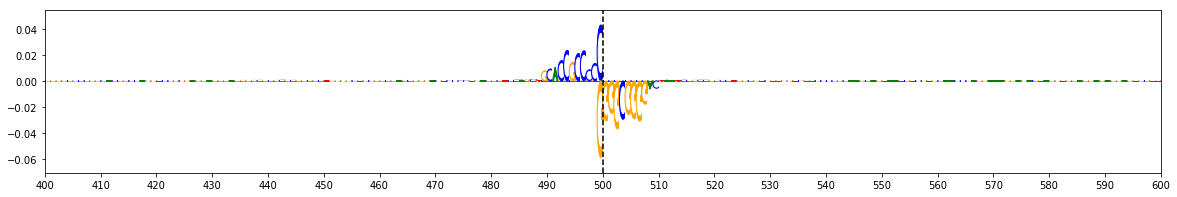


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3819118   ||    chr18 : 51198353 - 51198354   ||    Locus: 96   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  3.41E-04

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.0284   ||   Center / 200bp : 0.6845
Noneffect Sequence : CCGCTGGCCCGGCTTCTCTG


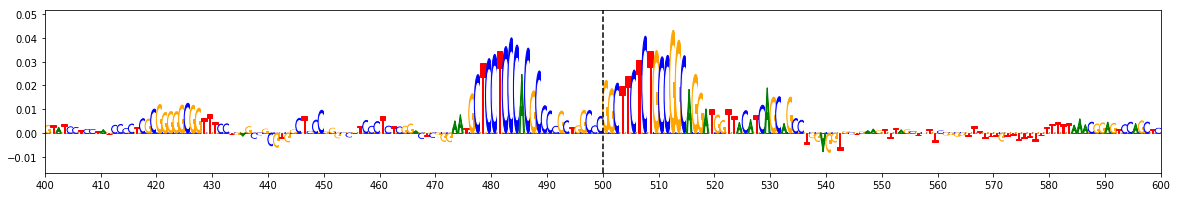

Effect Allele : T   ||   Explain Score : 0.9134   ||   Center / 200bp : 0.6584
Effect Sequence : CCGCTGGCCTGGCTTCTCTG


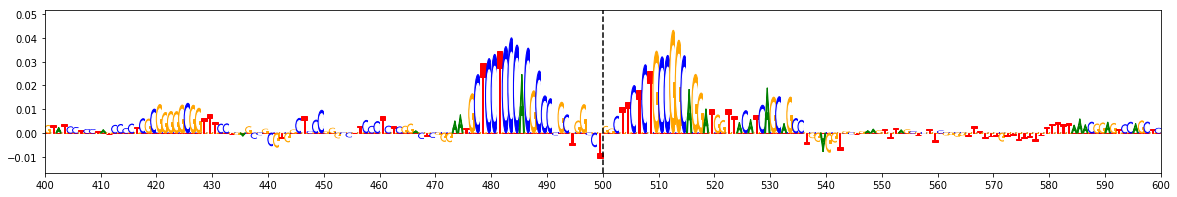

Allele Ratio : 0.8882   ||   Allele Difference : -0.1381  ||  ISM Score : -0.219  ||  deltaSVM Score : -1.2621


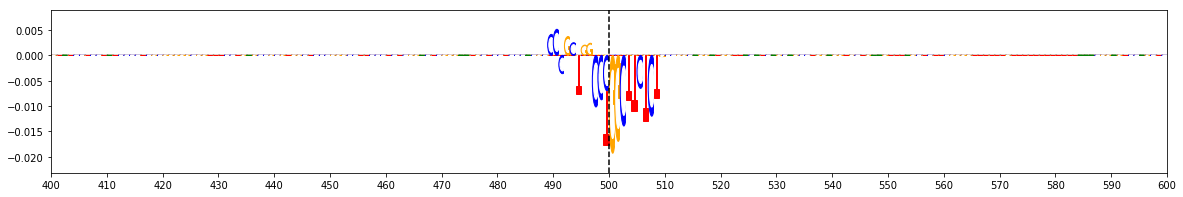


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1372519   ||    chr4 : 89836157 - 89836158   ||    Locus: 192   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  5.25E-08
23andme_PD_hg38 		  2.92E-15

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.5644   ||   Center / 200bp : 0.4603
Noneffect Sequence : GCAAACAGCGGGCCCAAGTG


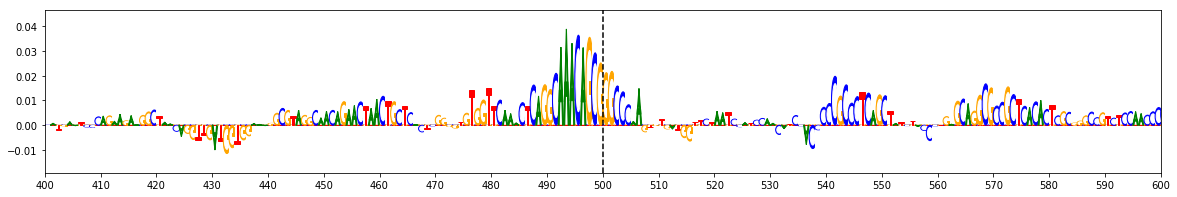

Effect Allele : A   ||   Explain Score : 0.3438   ||   Center / 200bp : 0.3419
Effect Sequence : GCAAACAGCAGGCCCAAGTG


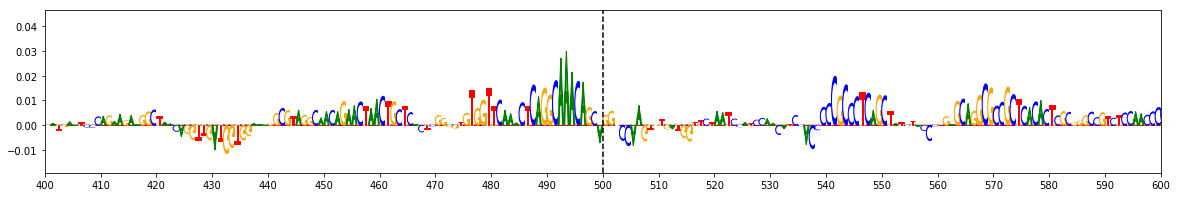

Allele Ratio : 0.6091   ||   Allele Difference : -0.2548  ||  ISM Score : -0.3983  ||  deltaSVM Score : -2.277


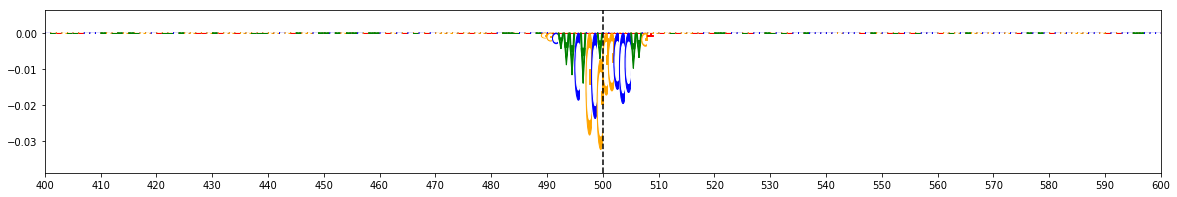


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: 17_45941122   ||    chr17 : 45941121 - 45941122   ||    Locus: 74   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  6.17E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.7983   ||   Center / 200bp : 0.5989
Noneffect Sequence : CAAACCAGCCTCTGCAGGCC


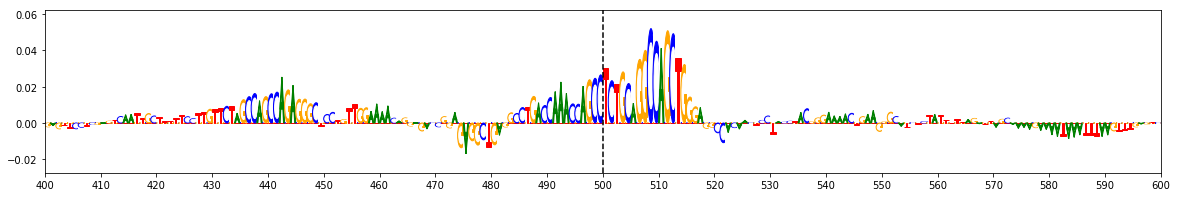

Effect Allele : T   ||   Explain Score : 0.642   ||   Center / 200bp : 0.5451
Effect Sequence : CAAACCAGCTTCTGCAGGCC


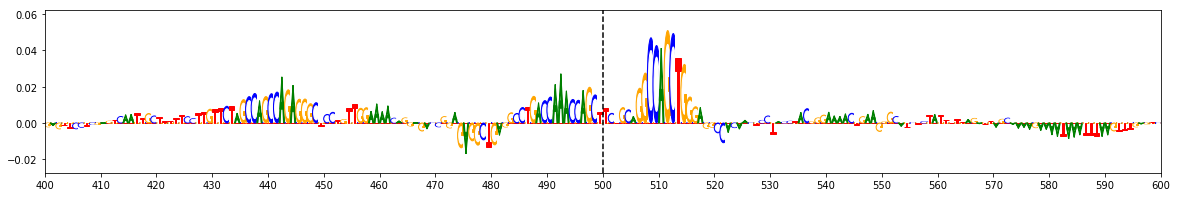

Allele Ratio : 0.8042   ||   Allele Difference : -0.1565  ||  ISM Score : -0.2461  ||  deltaSVM Score : -1.396


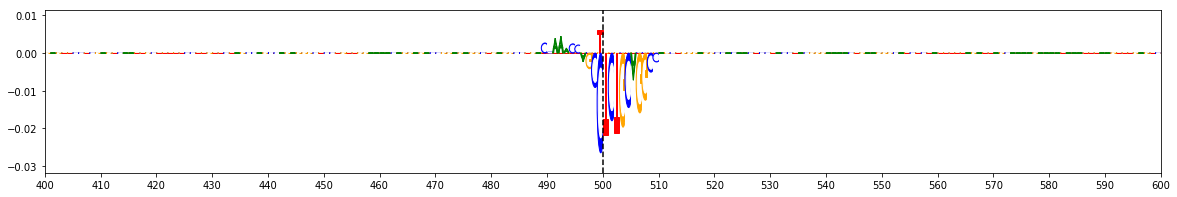


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7248162   ||    chr19 : 44951428 - 44951429   ||    Locus: 122   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  7.39E-10
Alzheimers_Kunkle_2019 		  1.14E-13
Alzheimers_Lambert_2013 	  5.51E-11

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.8616   ||   Center / 200bp : 0.6273
Noneffect Sequence : GCTGCCAAGCGCAGGGGGTG


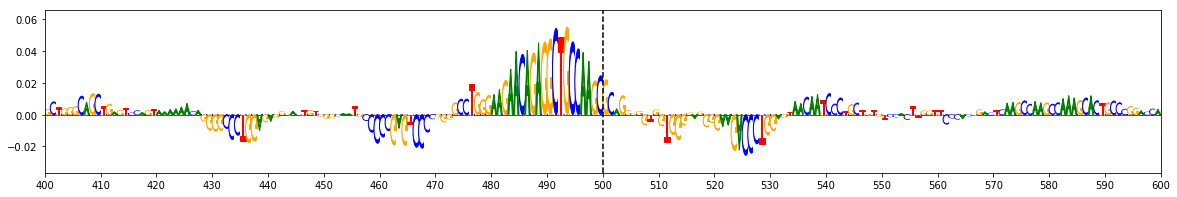

Effect Allele : T   ||   Explain Score : 0.7565   ||   Center / 200bp : 0.5963
Effect Sequence : GCTGCCAAGTGCAGGGGGTG


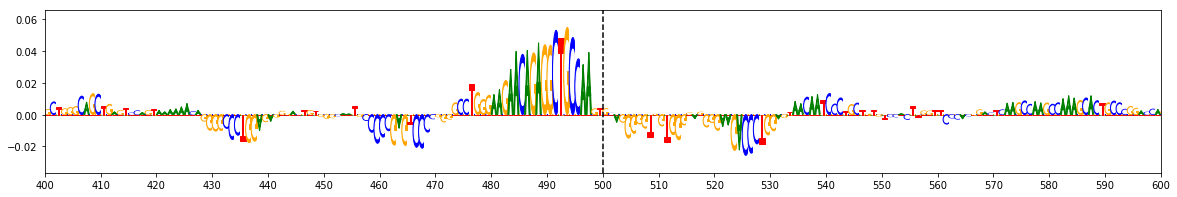

Allele Ratio : 0.878   ||   Allele Difference : -0.1593  ||  ISM Score : -0.2516  ||  deltaSVM Score : -1.4394


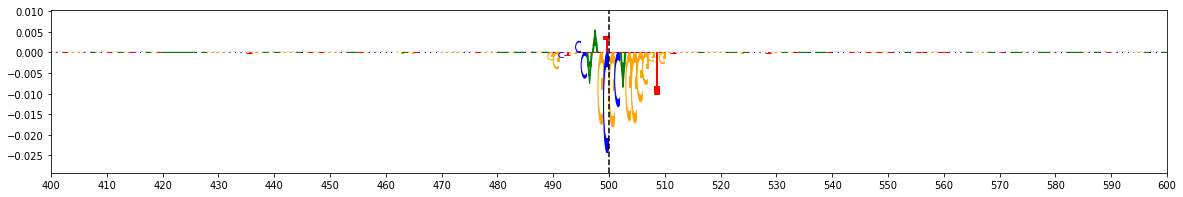


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1388597   ||    chr12 : 40224294 - 40224295   ||    Locus: 25   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.37E-03

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.4957   ||   Center / 200bp : 0.5924
Noneffect Sequence : CTCACAGGGAAACAATGTTT


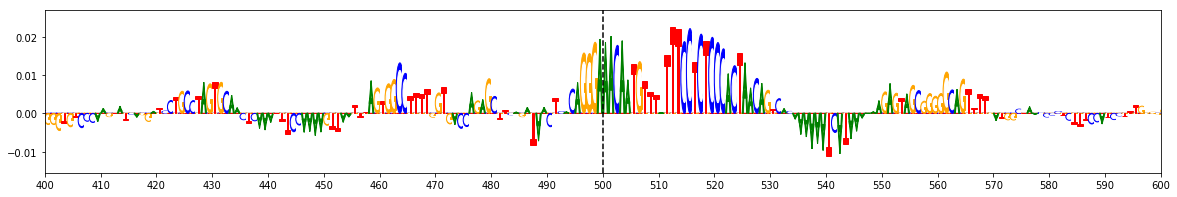

Effect Allele : G   ||   Explain Score : 0.4176   ||   Center / 200bp : 0.5499
Effect Sequence : CTCACAGGGGAACAATGTTT


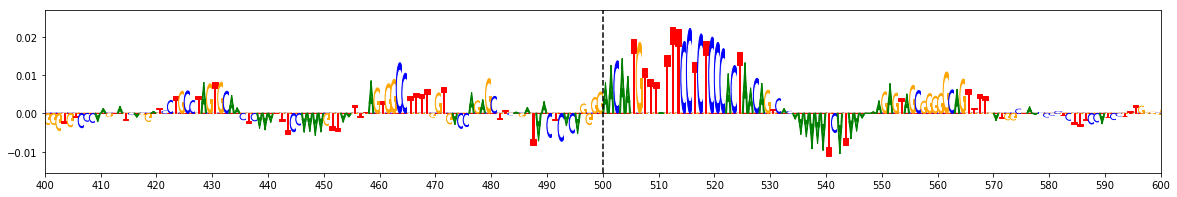

Allele Ratio : 0.8424   ||   Allele Difference : -0.1068  ||  ISM Score : -0.1646  ||  deltaSVM Score : -0.9708


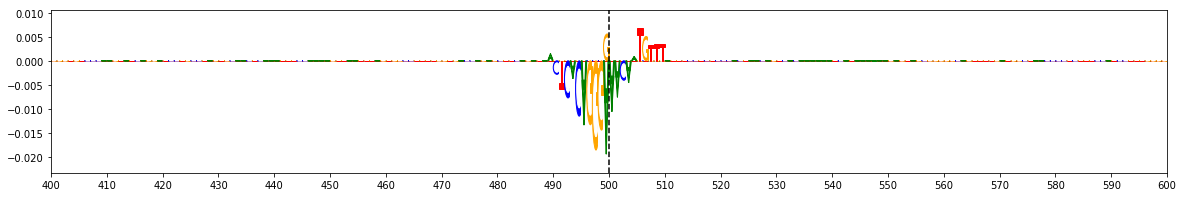


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062785   ||    chr17 : 45947195 - 45947196   ||    Locus: 78   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.33E-22

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.7058   ||   Center / 200bp : 0.5183
Noneffect Sequence : CTCCCAGTGGCTGCCTGTGT


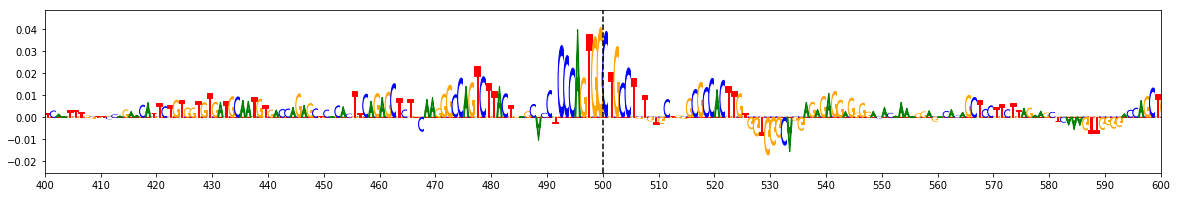

Effect Allele : T   ||   Explain Score : 0.5225   ||   Center / 200bp : 0.4434
Effect Sequence : CTCCCAGTGTCTGCCTGTGT


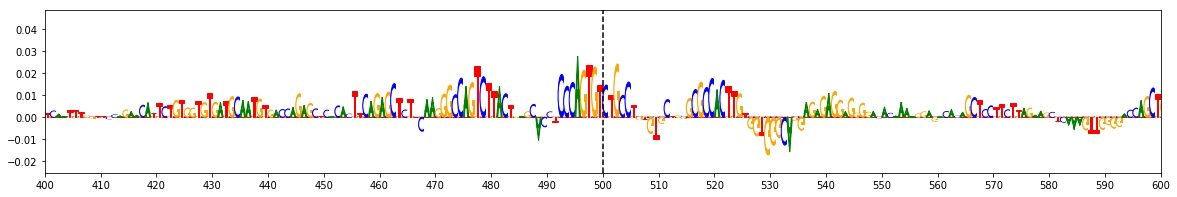

Allele Ratio : 0.7403   ||   Allele Difference : -0.2014  ||  ISM Score : -0.3151  ||  deltaSVM Score : -1.8617


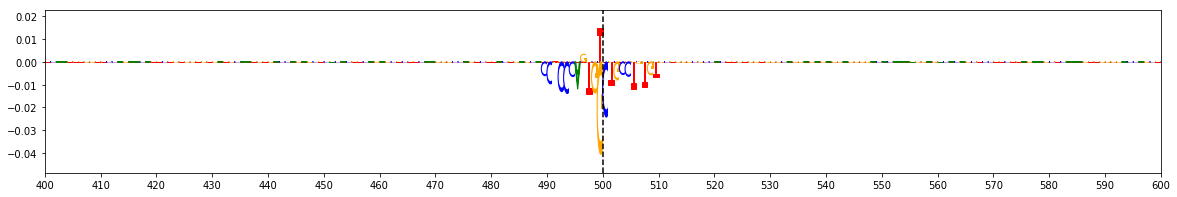


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062770   ||    chr17 : 45942313 - 45942314   ||    Locus: 76   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.67E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.5913   ||   Center / 200bp : 0.6694
Noneffect Sequence : CGTTTCTTCCTCCTTACAAA


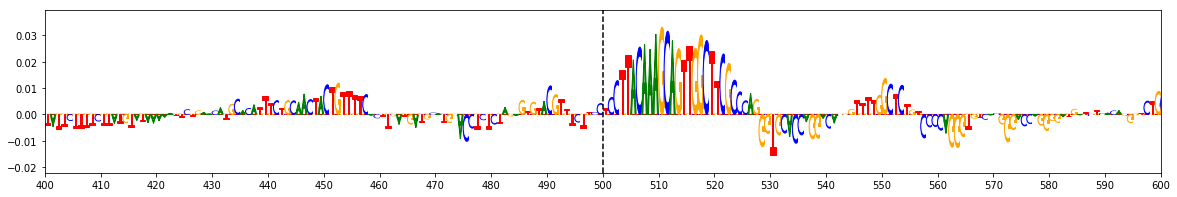

Effect Allele : T   ||   Explain Score : 0.5776   ||   Center / 200bp : 0.6642
Effect Sequence : CGTTTCTTCTTCCTTACAAA


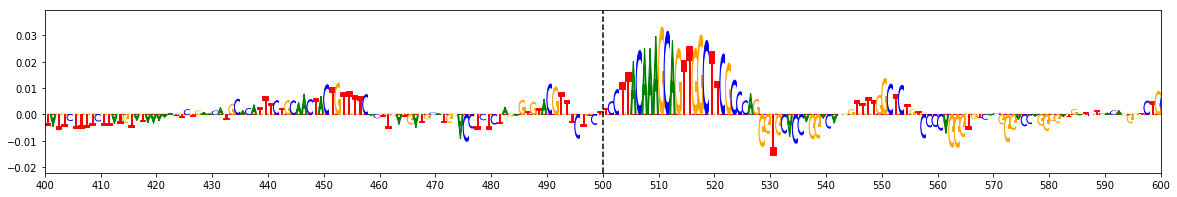

Allele Ratio : 0.9768   ||   Allele Difference : -0.022  ||  ISM Score : -0.0343  ||  deltaSVM Score : -0.1843


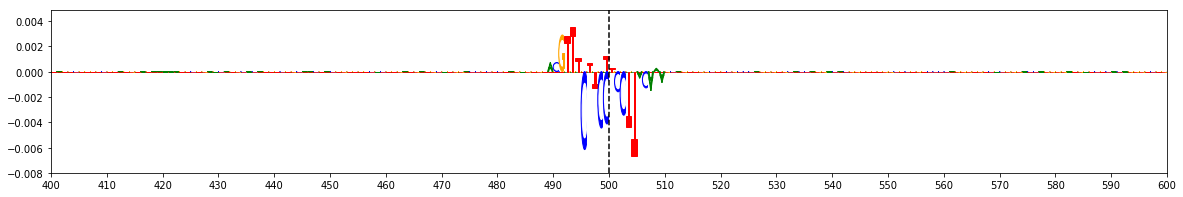


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs896434   ||    chr10 : 15515276 - 15515277   ||    Locus: 8   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  4.87E-04
Nalls_23andMe 		  4.87E-04

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.8578   ||   Center / 200bp : 0.6227
Noneffect Sequence : CAGTGCTCAGCCGTAGTCAG


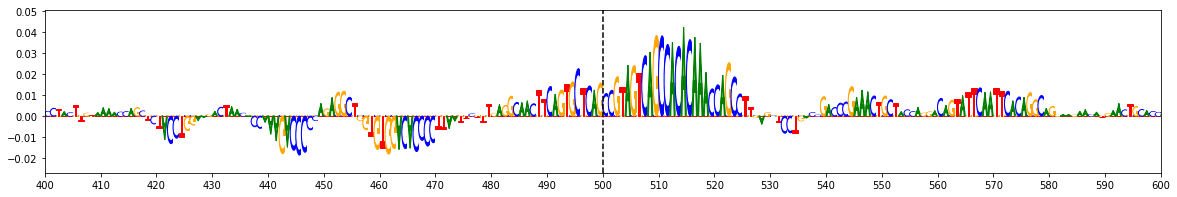

Effect Allele : T   ||   Explain Score : 0.785   ||   Center / 200bp : 0.6016
Effect Sequence : CAGTGCTCATCCGTAGTCAG


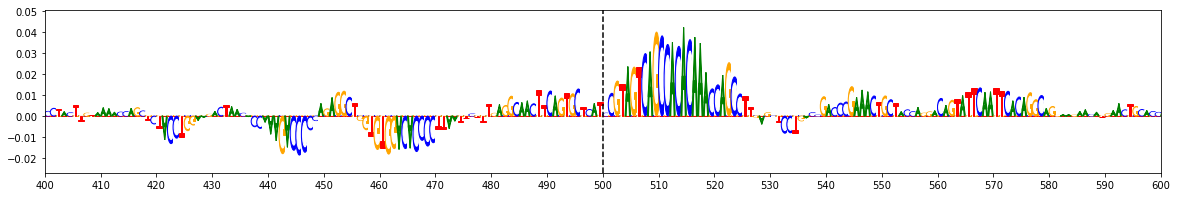

Allele Ratio : 0.9151   ||   Allele Difference : -0.0728  ||  ISM Score : -0.1129  ||  deltaSVM Score : -0.6577


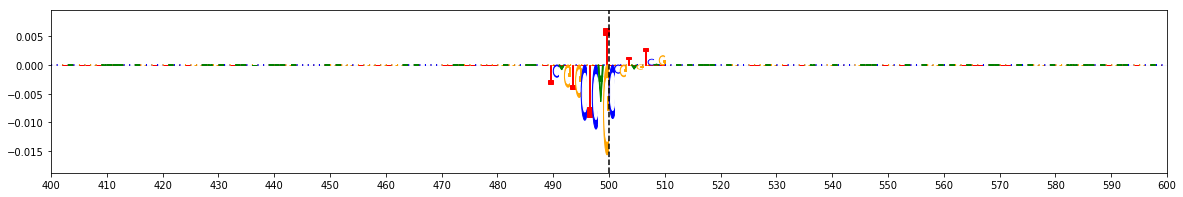


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 202   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.08E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.3658   ||   Center / 200bp : 0.4101
Noneffect Sequence : GGGTTGAGGCGGCTGCTGGG


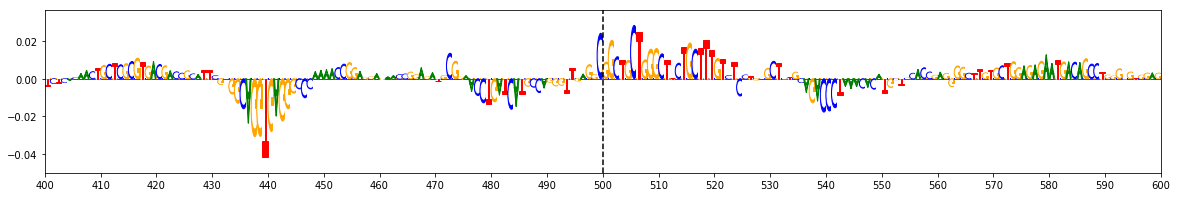

Effect Allele : T   ||   Explain Score : 0.2211   ||   Center / 200bp : 0.296
Effect Sequence : GGGTTGAGGTGGCTGCTGGG


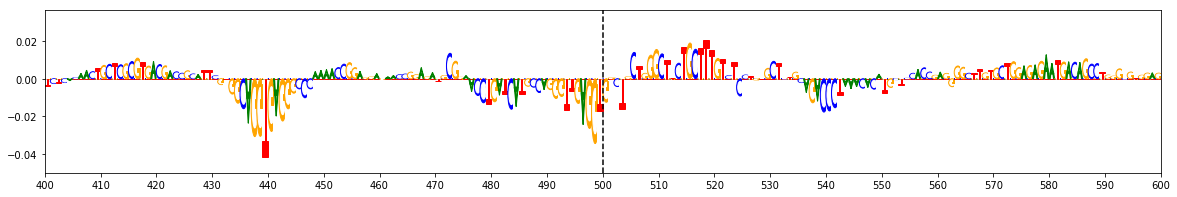

Allele Ratio : 0.6044   ||   Allele Difference : -0.3237  ||  ISM Score : -0.5062  ||  deltaSVM Score : -2.9072


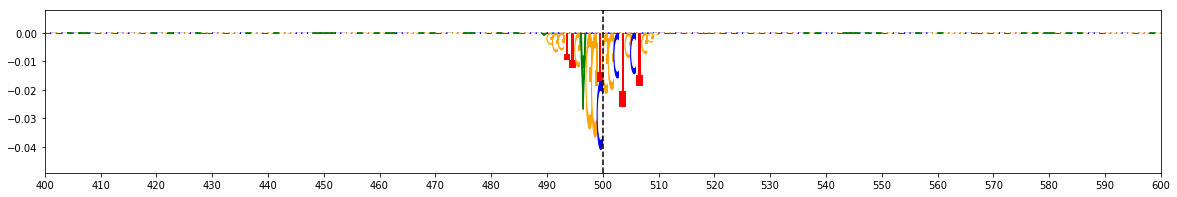


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
79   chr17   45947293   45947294   rs62062786      G         C   G    A,C   
213   chr8   22599691   22599692     rs755934      T         G   T      G   
58   chr17   45826181   45826182   rs62057150      T         C   C      T   
201   chr5  102910380  102910381   rs35100629      G         C   C      G   
180   chr4     987143     987144   rs10902762      G         A   G      A   
90   chr17   46771150   46771151     rs199523      C         A   C      A   
155   chr2  134719288  134719289   rs62171396      T         C   C      T   
135  chr19   45137506   45137507  rs536518226      C         G   G      C   
153   chr2  134718389  134718390   rs62171393      G         C   C      G   
219   chr8   22626782   22626783   rs10110443      G         C   C      G   
119  chr19   44911193   44911194     rs439401      T         C   T      C   
131  chr19   45039212   45039213   rs34034621      T         C   C      T   
91   chr17   62065808   62065809    rs3826419      G         C   C      G   
12   chr10  102245652  102245653    rs2296887      T         C   T      C   
152   chr2  134718237  134718238   rs13018063      G         A   G  A,C,T   
55   chr17   45825969   45825970   rs17763050      G         A   G      A   
77   chr17   45947185   45947186   rs62062784      G         C   C      G   
7    chr10   15515271   15515272     rs878320      G         C   G      C   
27   chr12  122842050  122842051   rs10847864      T         G   G  A,C,T   
167   chr3   52193272   52193273  rs140163861      T         C   C      T   
222   chr8   27608639   27608640    rs1532276      T         C   T      C   
21   chr11   86069405   86069406    rs3016327      T         C   T      C   
39   chr16   31106091   31106092    rs2032915      T         C   C      T   
60   chr17   45849388   45849389   rs62054820      G         A   A      G   
104  chr19   44644039   44644040   rs11540084      T         G   G      T   
82   chr17   46002354   46002355   rs62064662      G         A   A      G   
52   chr17   45748111   45748112   rs75715199      G         A   G      A   
133  chr19   45079143   45079144    rs7251911      G         C   C      G   
161   chr3   48685868   48685869    rs6792510      G         C   G      C   
45   chr17    5282069    5282070  rs113151753      G         C   C    G,T   
..     ...        ...        ...          ...    ...       ...  ..    ...   
126  chr19   44955205   44955206    rs8102895      A         G   A      G   
17   chr11   47354896   47354897    rs1057233      A         G   G      A   
18   chr11   47408352   47408353    rs7947450      A         G   G      A   
72   chr17   45940574   45940575   rs62061732      T         G   G      T   
13   chr10  119651404  119651405  rs144814361      T         C   C    A,T   
178   chr4     986675     986676    rs4690220      G         A   A      G   
66   chr17   45894114   45894115   rs80233201      T         C   T      C   
185   chr4   18022407   18022408    rs1380295      G         C   C    A,G   
209   chr7   23145875   23145876    rs6978475    NAN       NAN   A      G   
177   chr4     973656     973657   rs13137144      G         A   G    A,C   
210   chr7   23145879   23145880    rs6978478    NAN       NAN   A      G   
37   chr16   31074148   31074149    rs2303222      T         C   T    A,C   
65   chr17   45894090   45894091   rs76594404      G         C   G    A,C   
108  chr19   44758447   44758448   rs34967149      T         C   C      T   
6    chr10   15515115   15515116     rs878321      G         A   G      A   
54   chr17   45748209   45748210   rs62054437      T         C   T      C   
23   chr12   40105791   40105792  rs139518863      T         C   C      T   
215   chr8   22623005   22623006   rs11780207      G         A   G      A   
0     chr1  155135690  155135691   rs12726330      G         A   G    A,C   
43   chr17    5097731    5097732   rs56152541      C         T   T      C   
86 

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs62062786   ||    chr17 : 45947293 - 45947294   ||    Locus: 79   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  4.53E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.3686   ||  Center / 200bp: 0.4511
Effect Sequence: TGGGGACCAGCTGCCACAGA


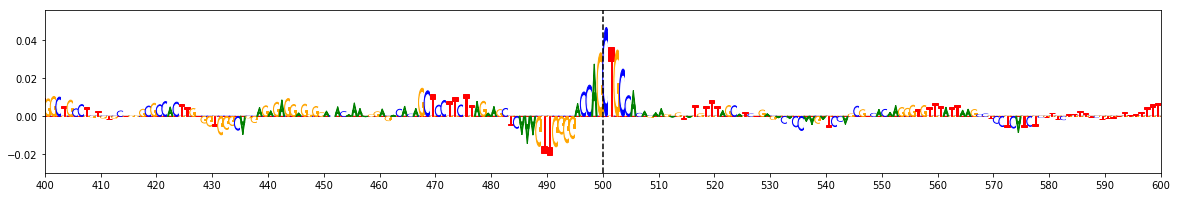

Noneffect Allele: C   ||  Explain Score: 0.0985   ||  Center / 200bp: 0.1801
Noneffect Sequence: TGGGGACCACCTGCCACAGA


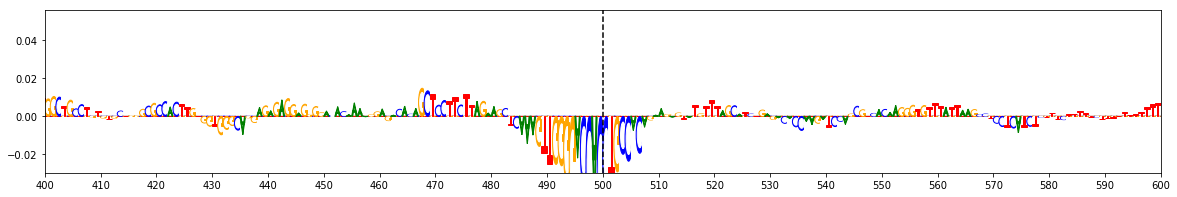

Allele Ratio : 3.743   ||   Allele Difference : 0.7655  ||  ISM Score : 1.2475  ||  deltaSVM Score : 7.1206


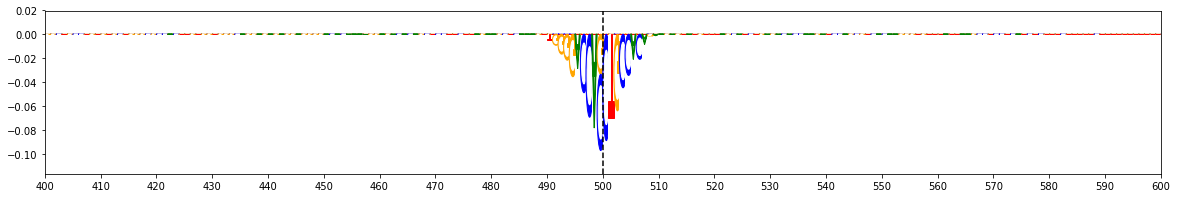


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755934   ||    chr8 : 22599691 - 22599692   ||    Locus: 213   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.11E-02
Nalls_23andMe 		  5.11E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5963   ||  Center / 200bp: 0.5498
Effect Sequence: GCGGCTGCATTGGCCGGGGC


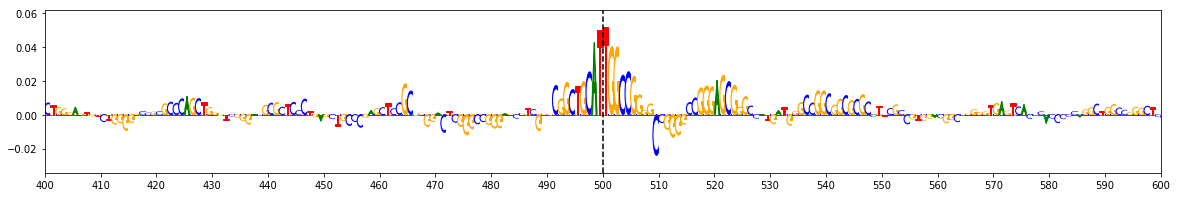

Noneffect Allele: G   ||  Explain Score: 0.3245   ||  Center / 200bp: 0.4007
Noneffect Sequence: GCGGCTGCAGTGGCCGGGGC


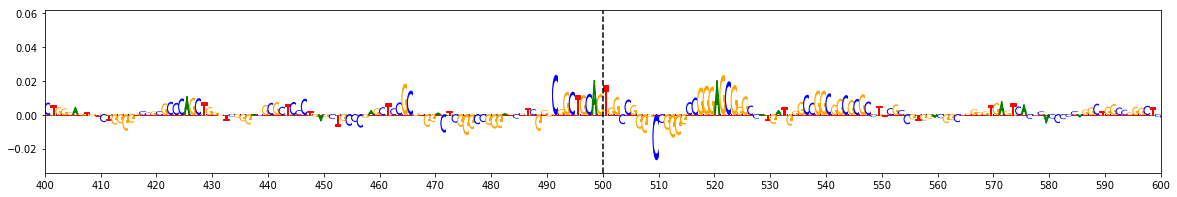

Allele Ratio : 1.8376   ||   Allele Difference : 0.3001  ||  ISM Score : 0.4773  ||  deltaSVM Score : 2.9934


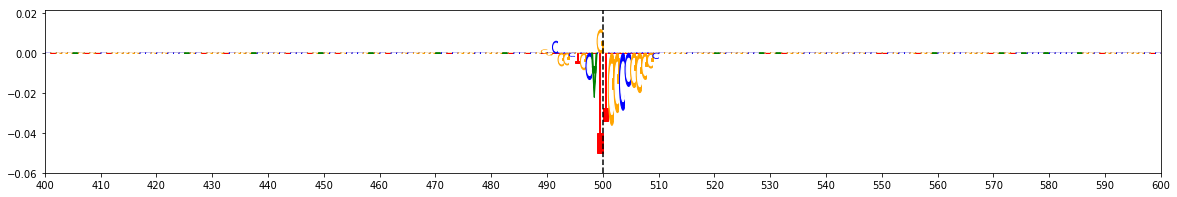


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62057150   ||    chr17 : 45826181 - 45826182   ||    Locus: 58   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.33E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6561   ||  Center / 200bp: 0.6153
Effect Sequence: CGTGGCCATTGGTCGGGGTG


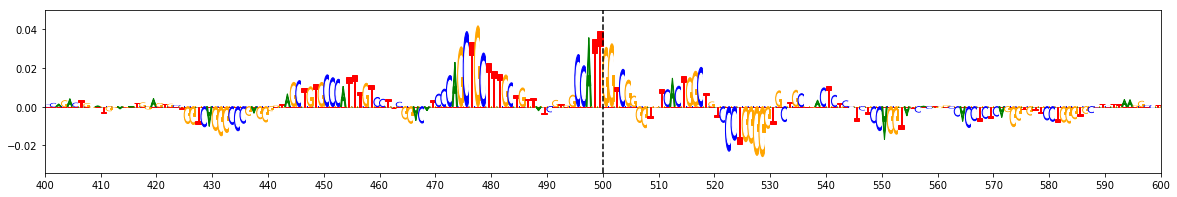

Noneffect Allele: C   ||  Explain Score: 0.4013   ||  Center / 200bp: 0.4941
Noneffect Sequence: CGTGGCCATCGGTCGGGGTG


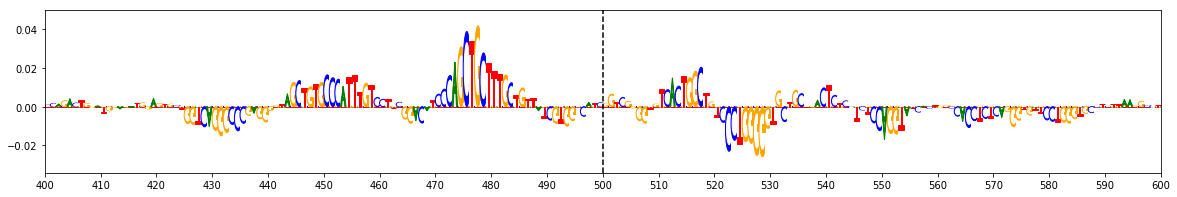

Allele Ratio : 1.6351   ||   Allele Difference : 0.2932  ||  ISM Score : 0.4658  ||  deltaSVM Score : 2.6638


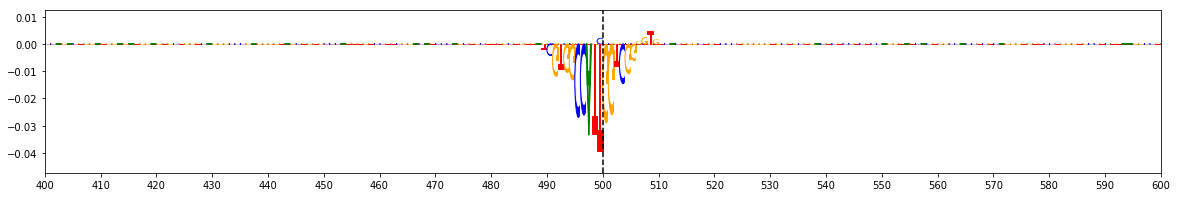


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs35100629   ||    chr5 : 102910380 - 102910381   ||    Locus: 201   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.86E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.5495   ||  Center / 200bp: 0.6448
Effect Sequence: TTGAGAAACGCTCCAACCTC


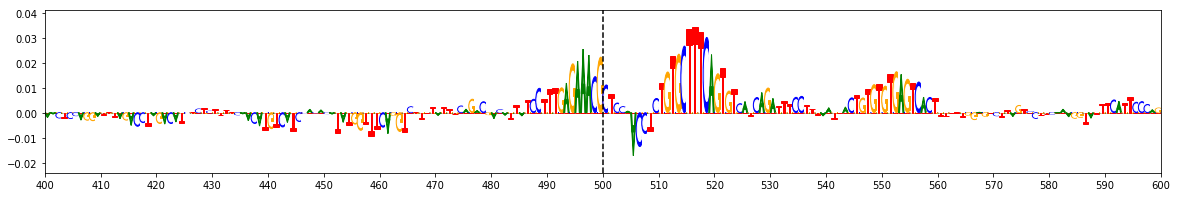

Noneffect Allele: C   ||  Explain Score: 0.377   ||  Center / 200bp: 0.5546
Noneffect Sequence: TTGAGAAACCCTCCAACCTC


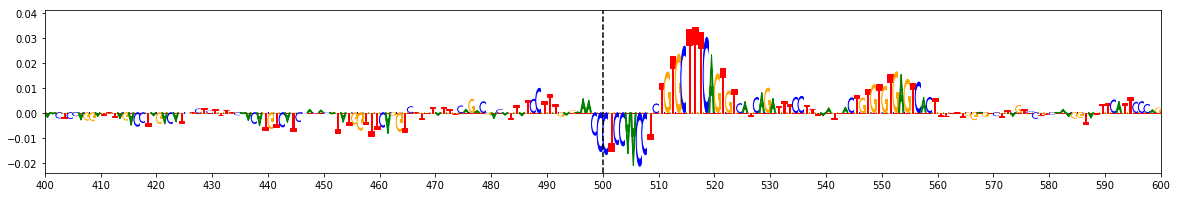

Allele Ratio : 1.4577   ||   Allele Difference : 0.2977  ||  ISM Score : 0.4636  ||  deltaSVM Score : 2.6764


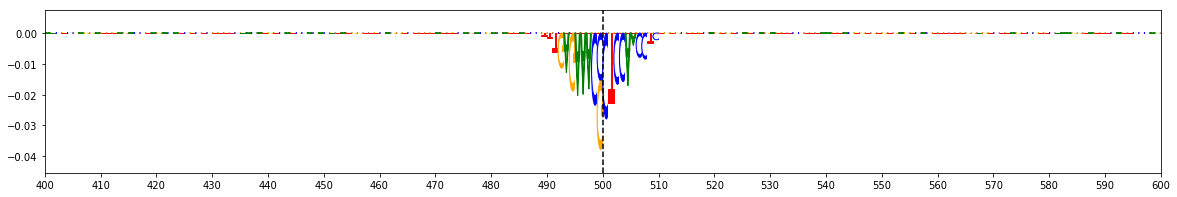


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 180   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.2627   ||  Center / 200bp: 0.4481
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


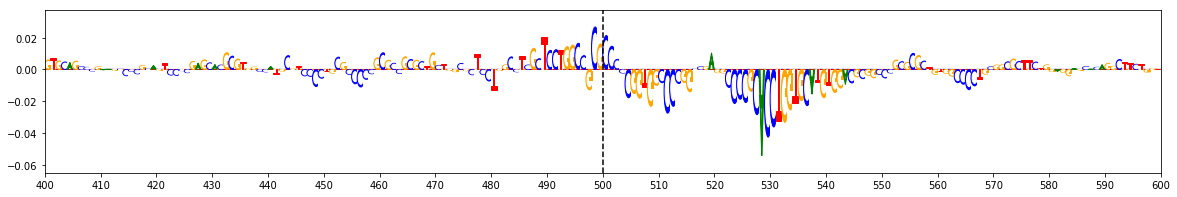

Noneffect Allele: A   ||  Explain Score: 0.126   ||  Center / 200bp: 0.2772
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


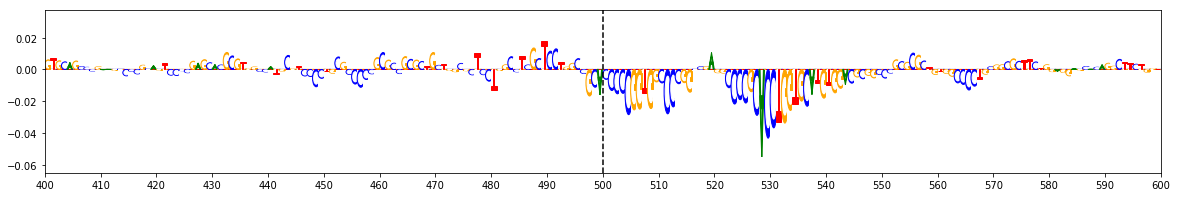

Allele Ratio : 2.0845   ||   Allele Difference : 0.2514  ||  ISM Score : 0.408  ||  deltaSVM Score : 2.4176


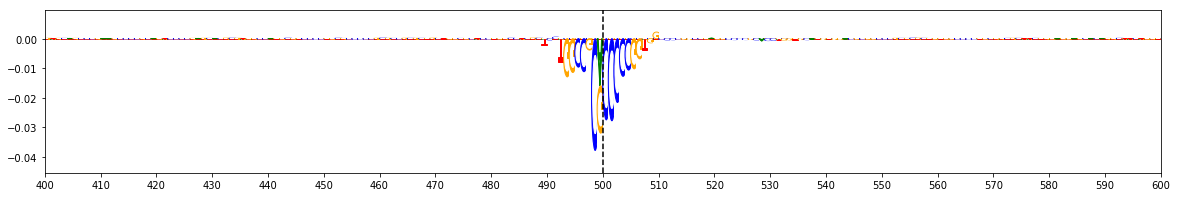


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 90   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.5386   ||  Center / 200bp: 0.3193
Effect Sequence: GCCCTCCTGCGCCACCTACA


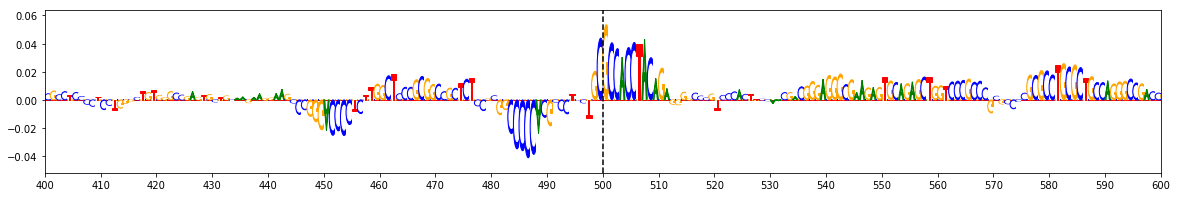

Noneffect Allele: A   ||  Explain Score: 0.1873   ||  Center / 200bp: 0.14
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


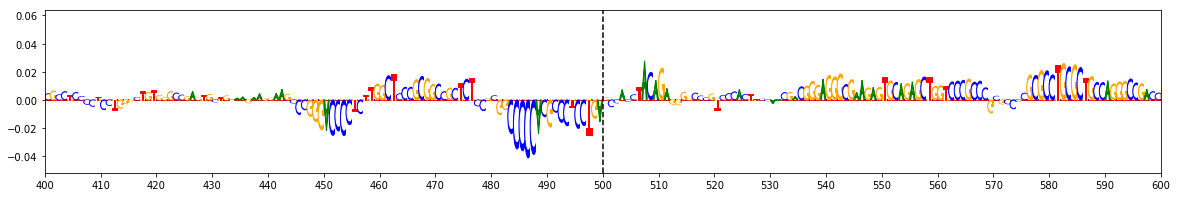

Allele Ratio : 2.8762   ||   Allele Difference : 0.4662  ||  ISM Score : 0.7392  ||  deltaSVM Score : 4.2675


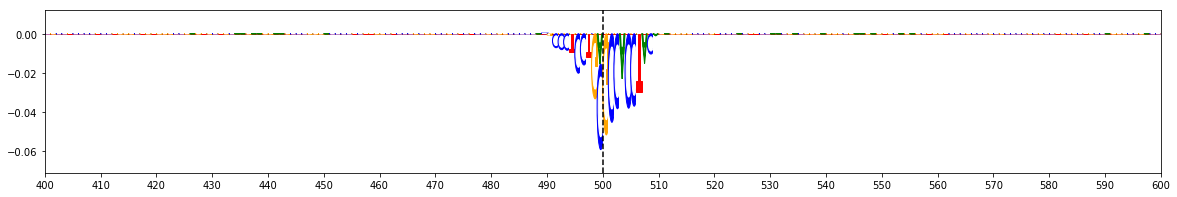


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 155   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.04E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.0103   ||  Center / 200bp: 0.6707
Effect Sequence: ACAGGCGGCTCTGGCAGAGC


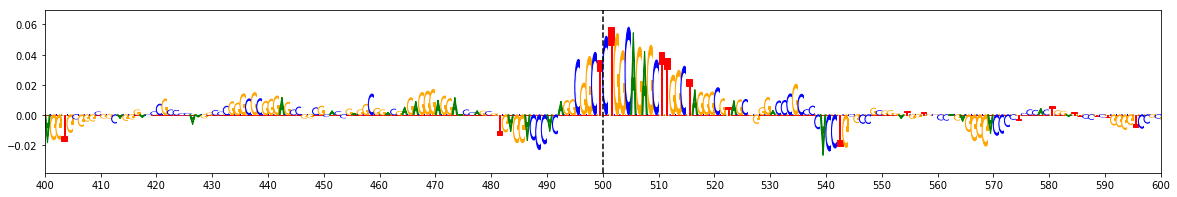

Noneffect Allele: C   ||  Explain Score: 0.9026   ||  Center / 200bp: 0.6442
Noneffect Sequence: ACAGGCGGCCCTGGCAGAGC


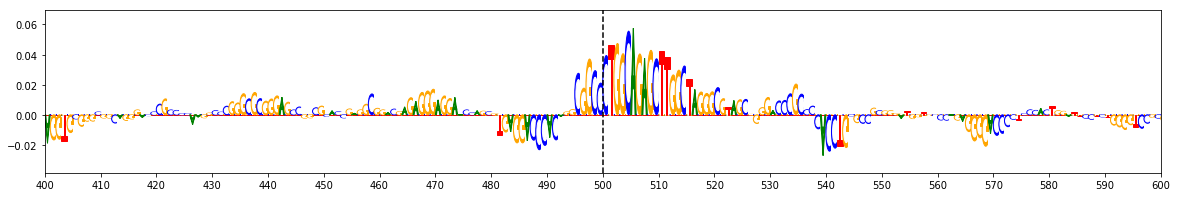

Allele Ratio : 1.1193   ||   Allele Difference : 0.1186  ||  ISM Score : 0.181  ||  deltaSVM Score : 1.0845


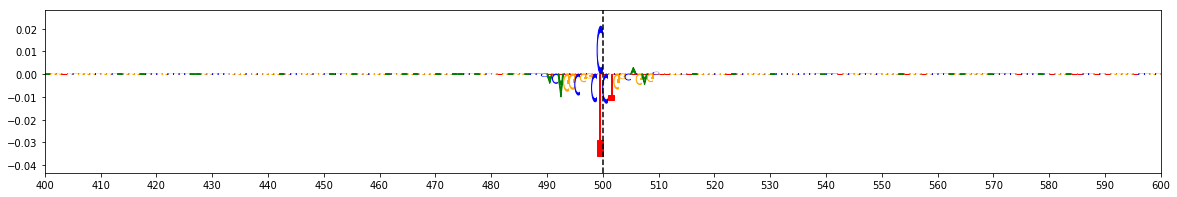


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs536518226   ||    chr19 : 45137506 - 45137507   ||    Locus: 135   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.88E-19

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.8451   ||  Center / 200bp: 0.5581
Effect Sequence: AGCTGTTGGCTTTGGGCTAC


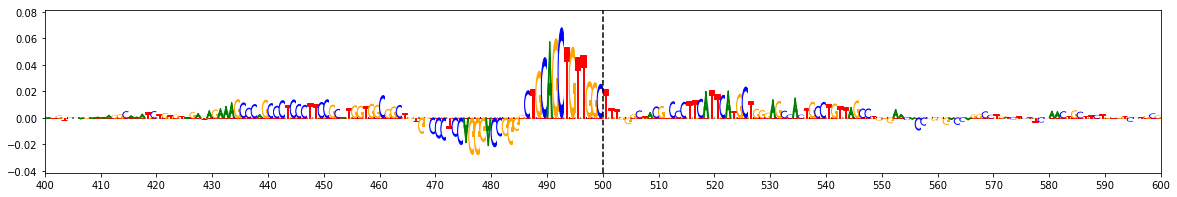

Noneffect Allele: G   ||  Explain Score: 0.6638   ||  Center / 200bp: 0.4977
Noneffect Sequence: AGCTGTTGGGTTTGGGCTAC


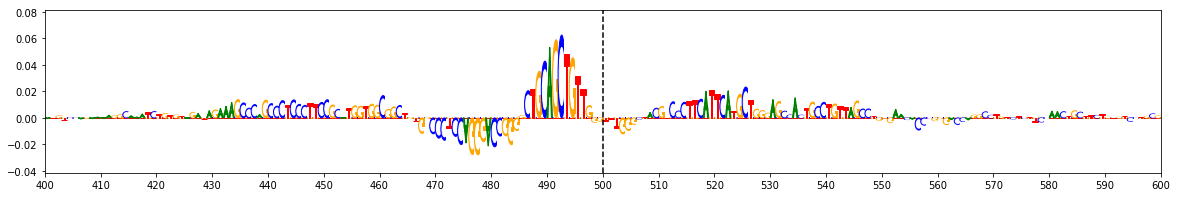

Allele Ratio : 1.2732   ||   Allele Difference : 0.2203  ||  ISM Score : 0.3447  ||  deltaSVM Score : 1.9798


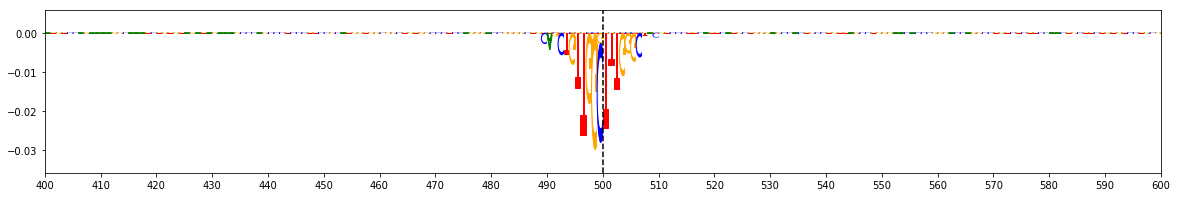


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171393   ||    chr2 : 134718389 - 134718390   ||    Locus: 153   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  9.02E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.6842   ||  Center / 200bp: 0.4848
Effect Sequence: CGGAGTGGCGCAGAAGCGCT


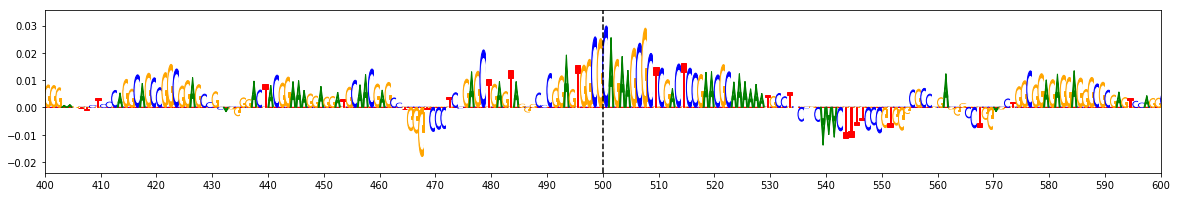

Noneffect Allele: C   ||  Explain Score: 0.4772   ||  Center / 200bp: 0.3961
Noneffect Sequence: CGGAGTGGCCCAGAAGCGCT


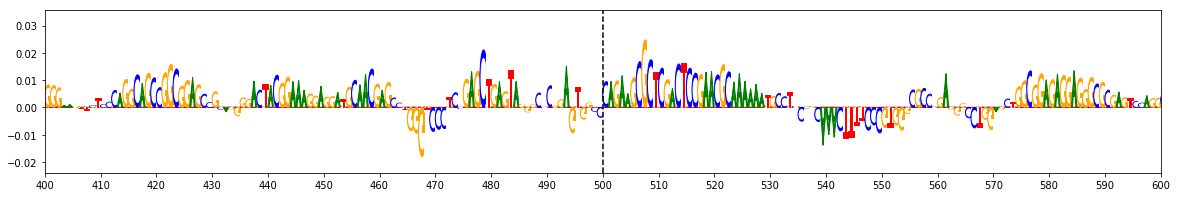

Allele Ratio : 1.434   ||   Allele Difference : 0.2259  ||  ISM Score : 0.3538  ||  deltaSVM Score : 2.0503


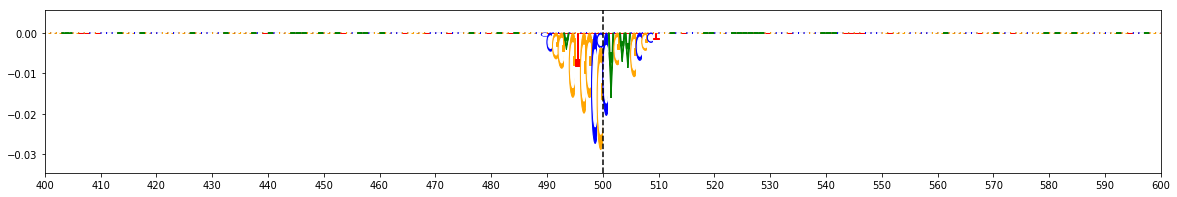


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10110443   ||    chr8 : 22626782 - 22626783   ||    Locus: 219   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.75E-02
Nalls_23andMe 		  2.75E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.5541   ||  Center / 200bp: 0.5932
Effect Sequence: GGAGGAGCCGTATGCTCGTT


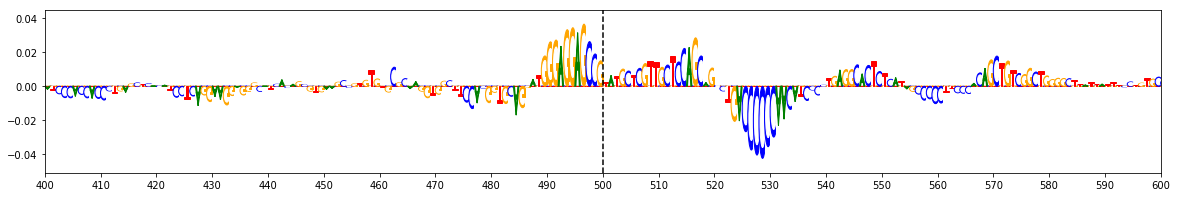

Noneffect Allele: C   ||  Explain Score: 0.4821   ||  Center / 200bp: 0.5591
Noneffect Sequence: GGAGGAGCCCTATGCTCGTT


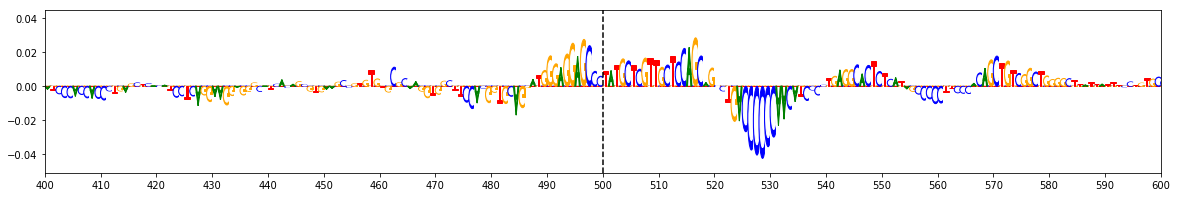

Allele Ratio : 1.1493   ||   Allele Difference : 0.072  ||  ISM Score : 0.1131  ||  deltaSVM Score : 0.6959


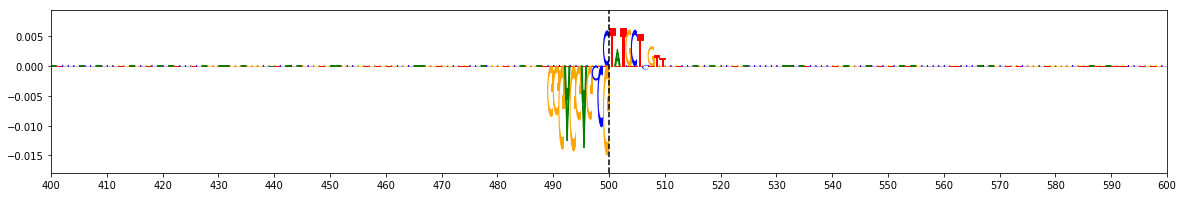


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs439401   ||    chr19 : 44911193 - 44911194   ||    Locus: 119   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.76E-165
Alzheimers_Kunkle_2019 		  7.61E-128
Alzheimers_Lambert_2013 	  3.54E-79

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.8205   ||  Center / 200bp: 0.5659
Effect Sequence: ACTCTCTTCTCCTCCCACCC


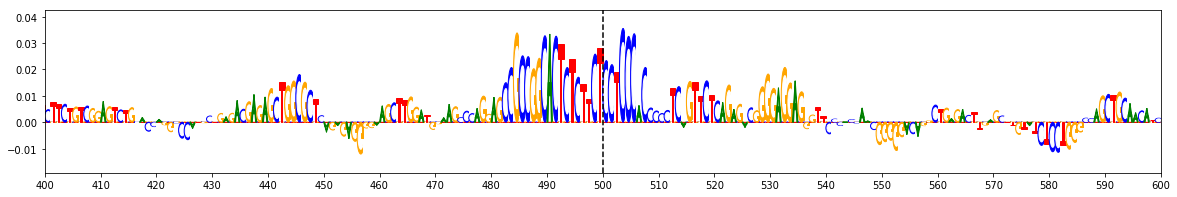

Noneffect Allele: C   ||  Explain Score: 0.6877   ||  Center / 200bp: 0.5229
Noneffect Sequence: ACTCTCTTCCCCTCCCACCC


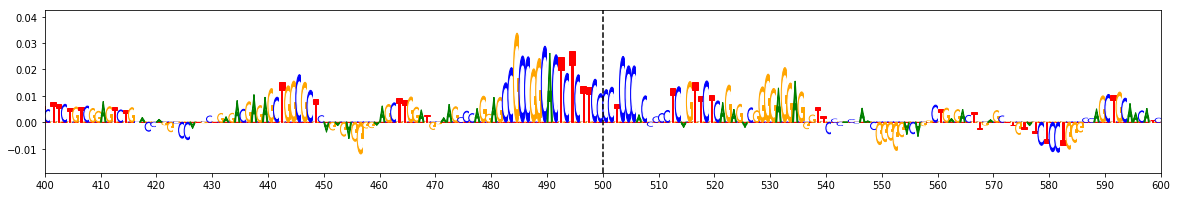

Allele Ratio : 1.1931   ||   Allele Difference : 0.1343  ||  ISM Score : 0.2091  ||  deltaSVM Score : 1.2323


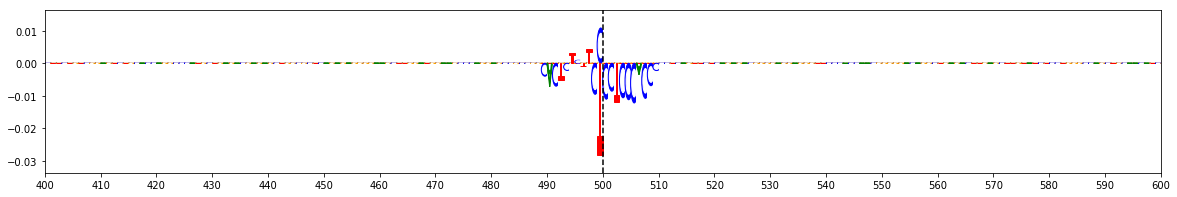


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 131   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.2987   ||  Center / 200bp: 0.4028
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


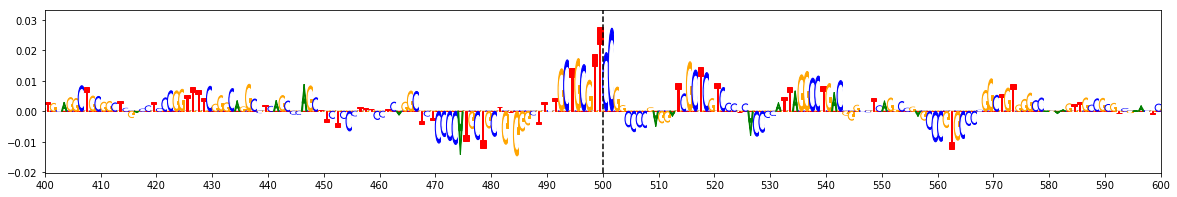

Noneffect Allele: C   ||  Explain Score: 0.1829   ||  Center / 200bp: 0.2925
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


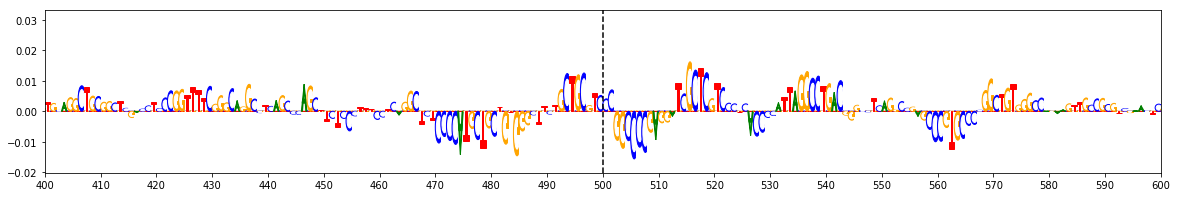

Allele Ratio : 1.6334   ||   Allele Difference : 0.1779  ||  ISM Score : 0.2817  ||  deltaSVM Score : 1.6376


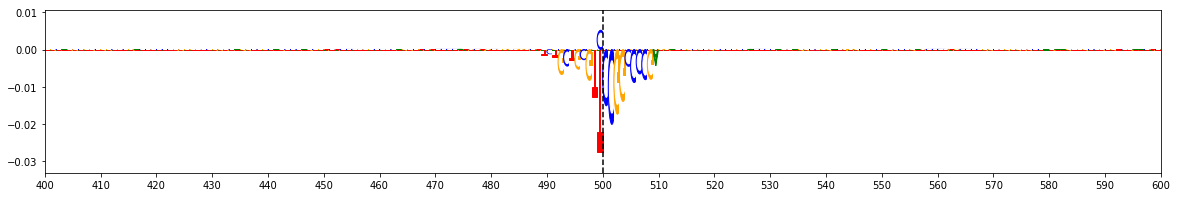


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3826419   ||    chr17 : 62065808 - 62065809   ||    Locus: 91   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.70E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.5438   ||  Center / 200bp: 0.4341
Effect Sequence: TTCCTGGGCGAAGCCGGCCT


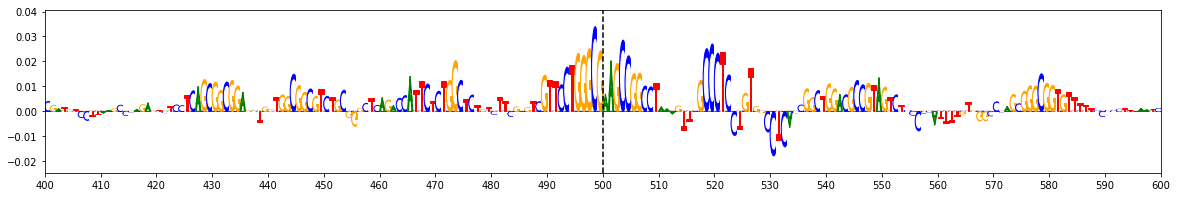

Noneffect Allele: C   ||  Explain Score: 0.3629   ||  Center / 200bp: 0.339
Noneffect Sequence: TTCCTGGGCCAAGCCGGCCT


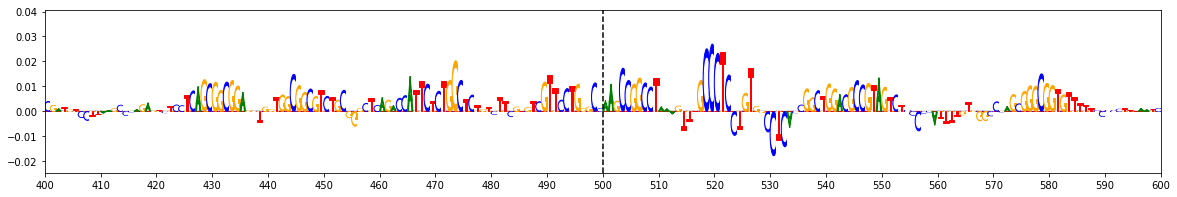

Allele Ratio : 1.4984   ||   Allele Difference : 0.1808  ||  ISM Score : 0.2829  ||  deltaSVM Score : 1.6114


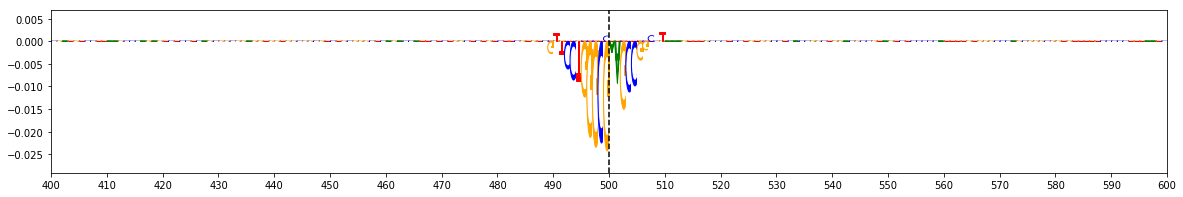


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2296887   ||    chr10 : 102245652 - 102245653   ||    Locus: 12   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.98E-03

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.6938   ||  Center / 200bp: 0.4516
Effect Sequence: GAAACAGGCTCCTTCTCTTC


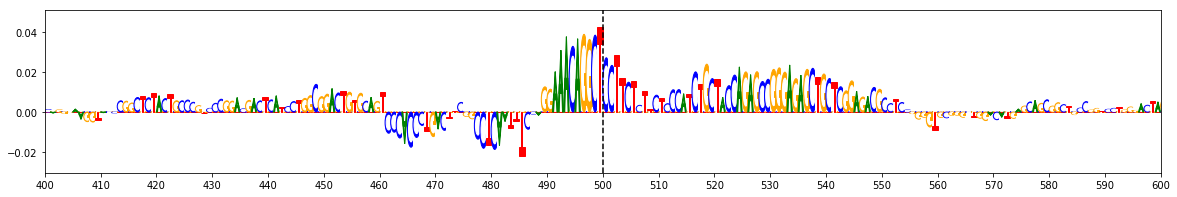

Noneffect Allele: C   ||  Explain Score: 0.4856   ||  Center / 200bp: 0.3657
Noneffect Sequence: GAAACAGGCCCCTTCTCTTC


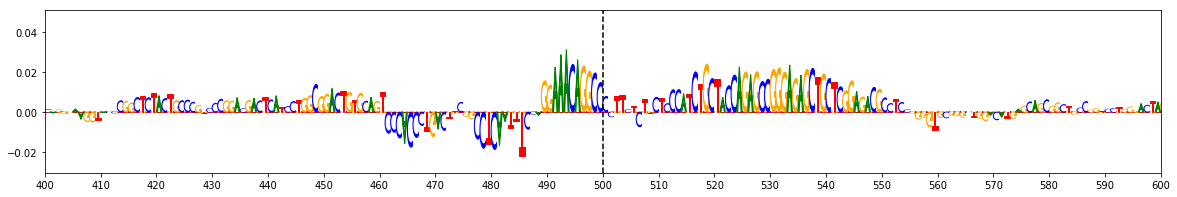

Allele Ratio : 1.4288   ||   Allele Difference : 0.2185  ||  ISM Score : 0.3401  ||  deltaSVM Score : 1.9431


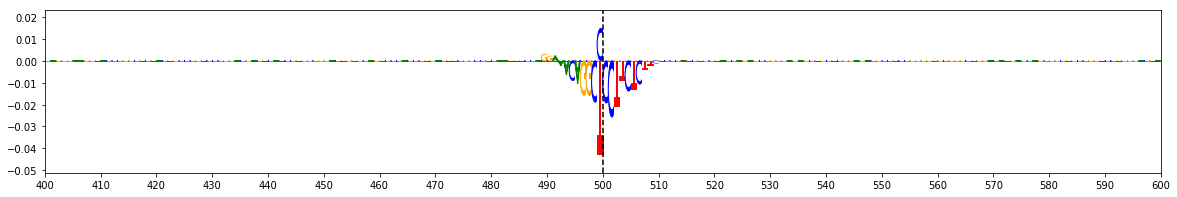


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs13018063   ||    chr2 : 134718237 - 134718238   ||    Locus: 152   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.00E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.1904   ||  Center / 200bp: 0.5315
Effect Sequence: CCCTTCGCCGGGGCGGGCAG


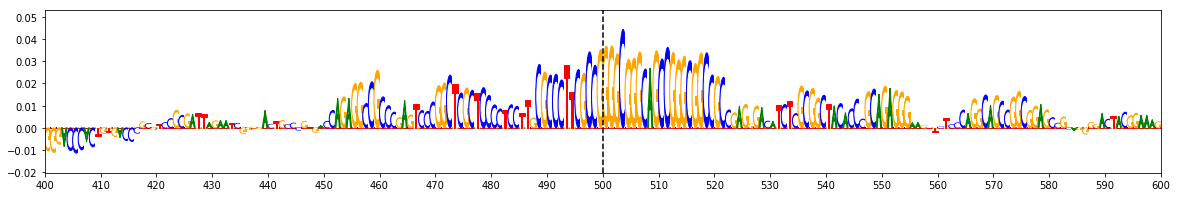

Noneffect Allele: A   ||  Explain Score: 1.0132   ||  Center / 200bp: 0.4909
Noneffect Sequence: CCCTTCGCCAGGGCGGGCAG


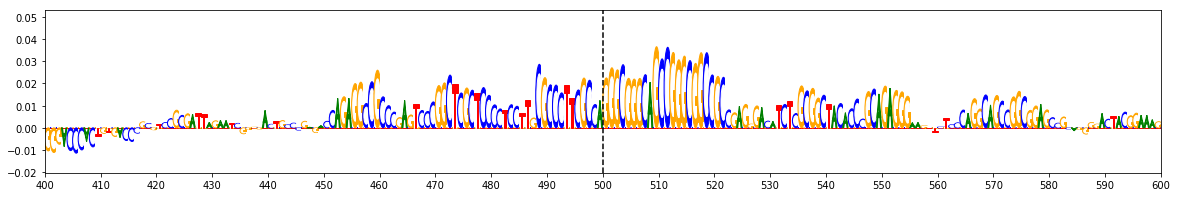

Allele Ratio : 1.1749   ||   Allele Difference : 0.1772  ||  ISM Score : 0.2815  ||  deltaSVM Score : 1.6612


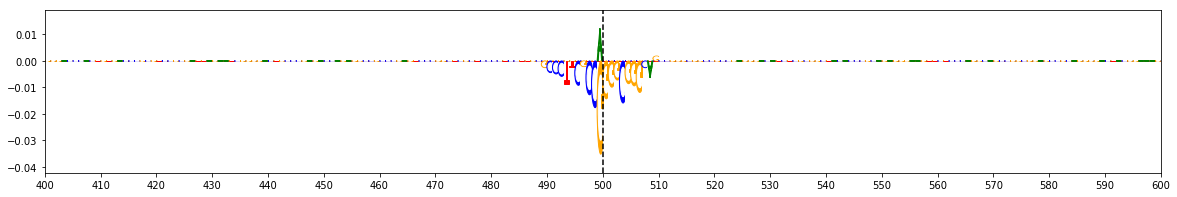


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17763050   ||    chr17 : 45825969 - 45825970   ||    Locus: 55   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.30E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7616   ||  Center / 200bp: 0.595
Effect Sequence: GAGTCAGCCGGGCACAAATT


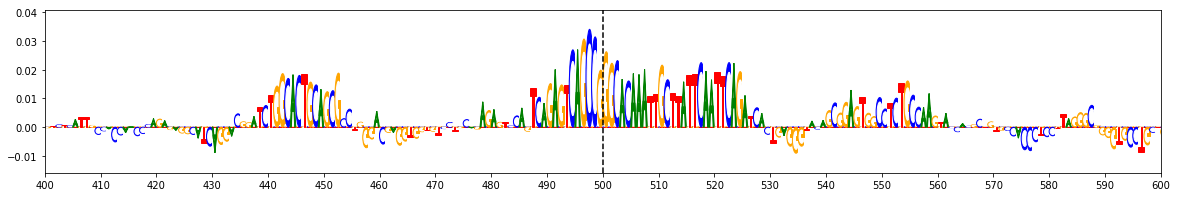

Noneffect Allele: A   ||  Explain Score: 0.7328   ||  Center / 200bp: 0.5857
Noneffect Sequence: GAGTCAGCCAGGCACAAATT


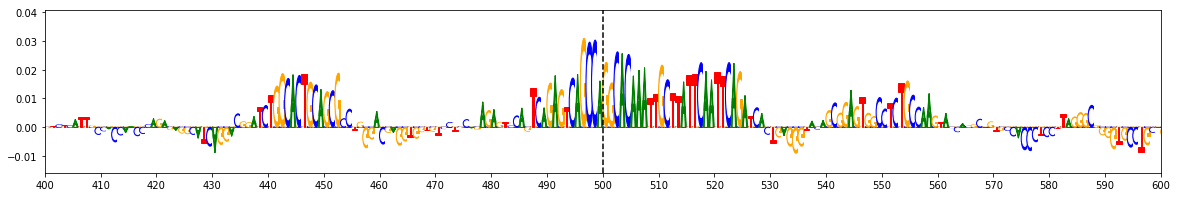

Allele Ratio : 1.0393   ||   Allele Difference : 0.0288  ||  ISM Score : 0.0447  ||  deltaSVM Score : 0.2806


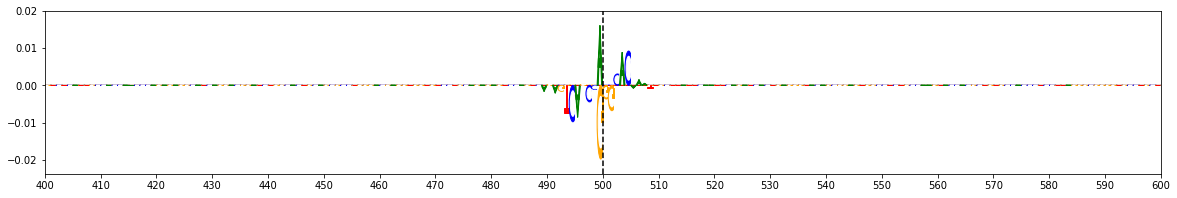


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062784   ||    chr17 : 45947185 - 45947186   ||    Locus: 77   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.33E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7741   ||  Center / 200bp: 0.5293
Effect Sequence: TACTGAGCAGCTCCCAGTGG


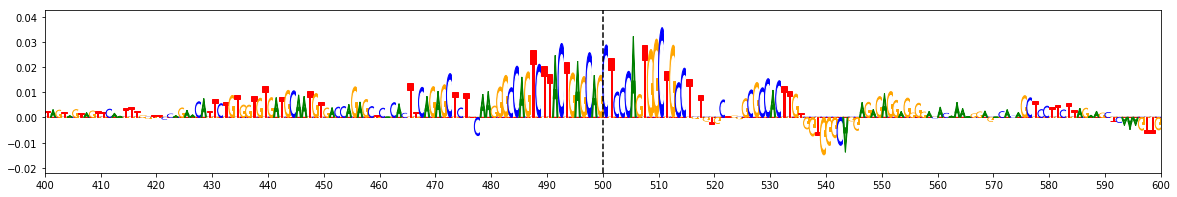

Noneffect Allele: C   ||  Explain Score: 0.6638   ||  Center / 200bp: 0.4905
Noneffect Sequence: TACTGAGCACCTCCCAGTGG


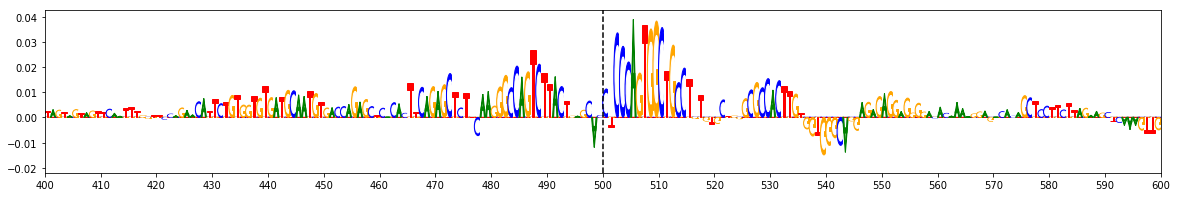

Allele Ratio : 1.1661   ||   Allele Difference : 0.1259  ||  ISM Score : 0.1971  ||  deltaSVM Score : 1.1731


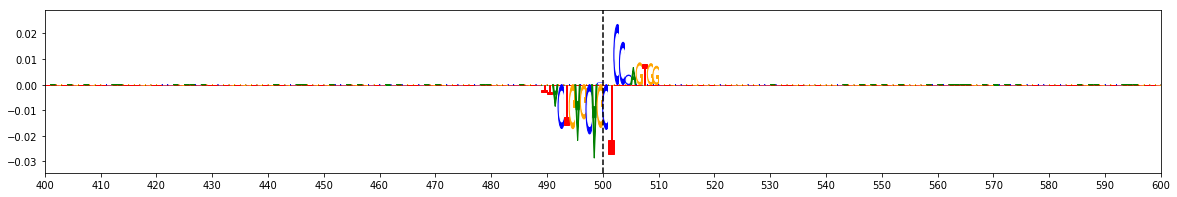


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs878320   ||    chr10 : 15515271 - 15515272   ||    Locus: 7   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  4.88E-04
Nalls_23andMe 		  4.88E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.6685   ||  Center / 200bp: 0.5292
Effect Sequence: AACTTCAGTGCTCATCCGTA


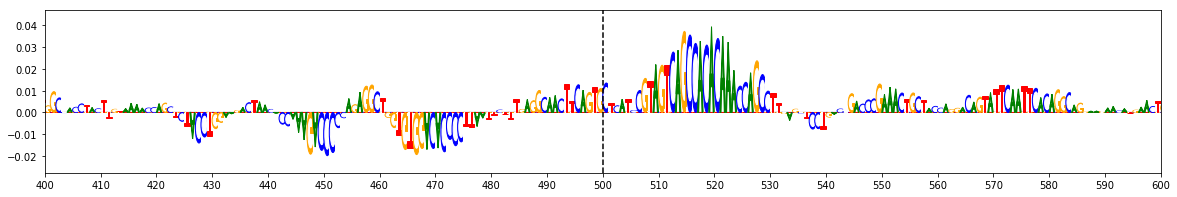

Noneffect Allele: C   ||  Explain Score: 0.578   ||  Center / 200bp: 0.4927
Noneffect Sequence: AACTTCAGTCCTCATCCGTA


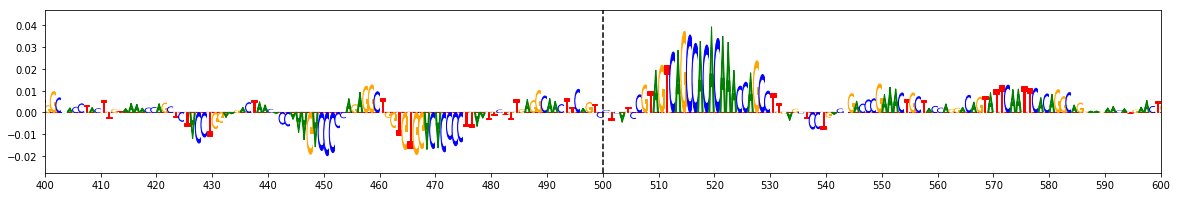

Allele Ratio : 1.1565   ||   Allele Difference : 0.1035  ||  ISM Score : 0.162  ||  deltaSVM Score : 0.9413


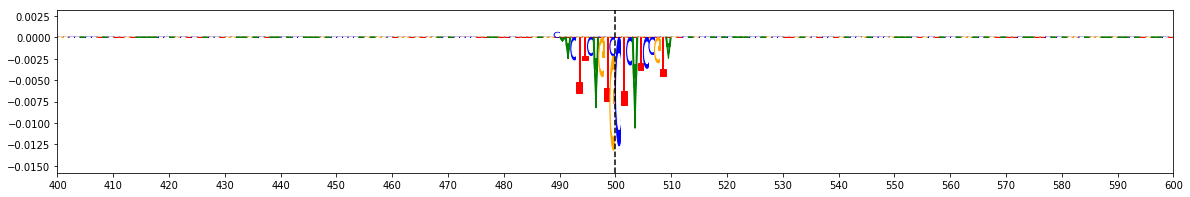


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10847864   ||    chr12 : 122842050 - 122842051   ||    Locus: 27   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  7.06E-14
Nalls_23andMe 		  7.06E-14

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6039   ||  Center / 200bp: 0.4487
Effect Sequence: CTGCTTTGCTTGTGGCCATA


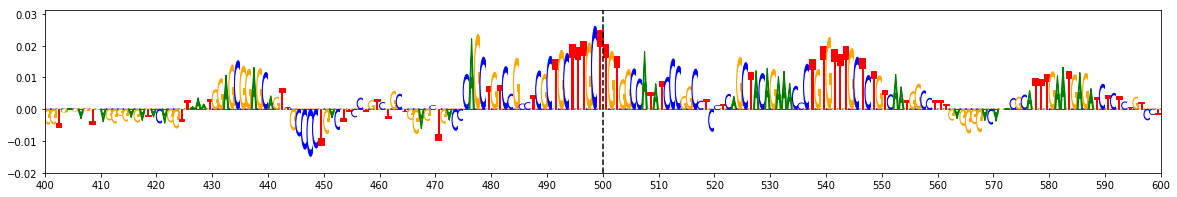

Noneffect Allele: G   ||  Explain Score: 0.4547   ||  Center / 200bp: 0.3801
Noneffect Sequence: CTGCTTTGCGTGTGGCCATA


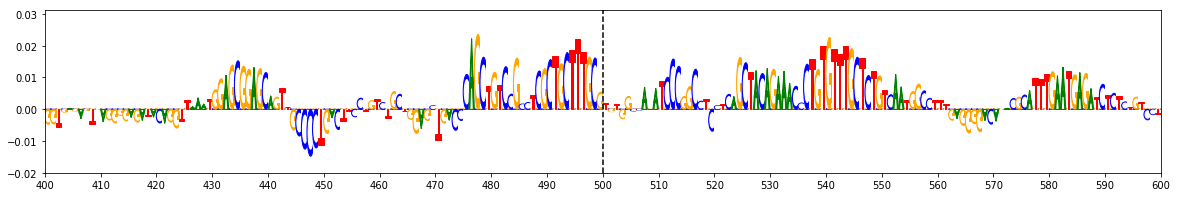

Allele Ratio : 1.328   ||   Allele Difference : 0.154  ||  ISM Score : 0.2398  ||  deltaSVM Score : 1.3866


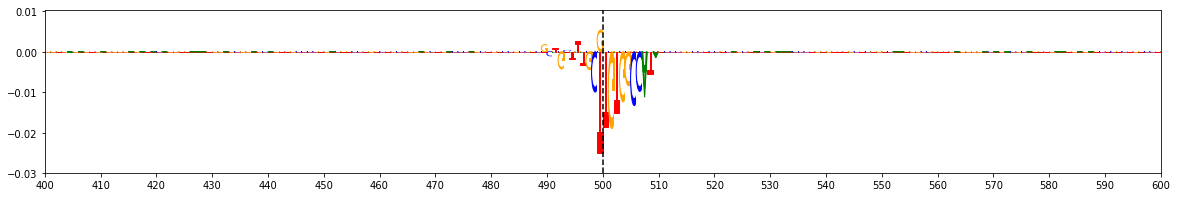


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs140163861   ||    chr3 : 52193272 - 52193273   ||    Locus: 167   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  1.26E-03

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.9132   ||  Center / 200bp: 0.503
Effect Sequence: CAGATGAGTTCACTGGGAGC


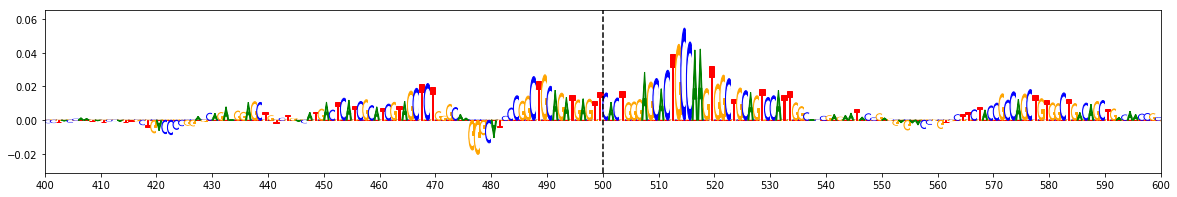

Noneffect Allele: C   ||  Explain Score: 0.7871   ||  Center / 200bp: 0.4666
Noneffect Sequence: CAGATGAGTCCACTGGGAGC


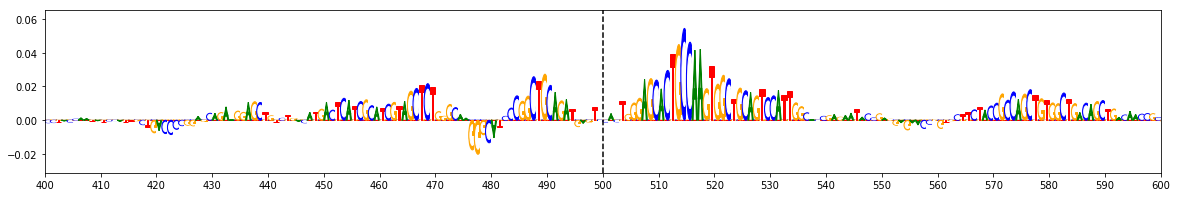

Allele Ratio : 1.1601   ||   Allele Difference : 0.1347  ||  ISM Score : 0.2069  ||  deltaSVM Score : 1.1788


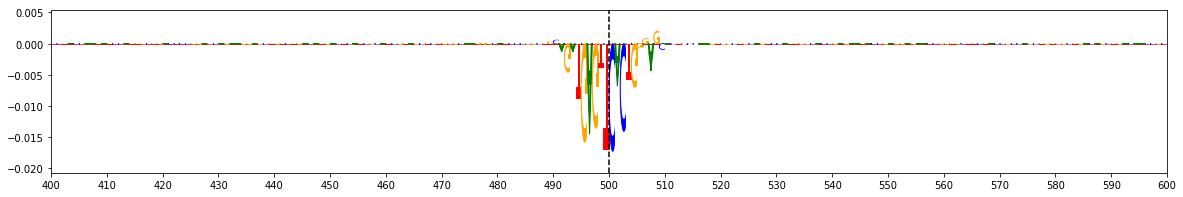


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()